In [82]:
!cat readme.txt
# !pip install sklearn

In [ ]:
# https://core.ac.uk/download/pdf/83461632.pdf

# https://www.emerald.com/insight/content/doi/10.1108/JSIT-10-2016-0061/full/pdf?casa_token=P8yIBuV70x4AAAAA:4rCEvt-IJa6g12I3JydKrI-RIP2sASgZYCBQdF7h49B3bWFlmtoLefn5cYIhmroh_6KIxUkWRTvm7R5PWPrf5sG11eNb4EzcstM7g0fjbcKh1kGFnGHk

In [2]:
import numpy as np 
import pandas as pd
import pyarrow
import sys

from datetime import datetime, timedelta
from matplotlib import pyplot as plt

import tqdm

%matplotlib inline

In [3]:
!pip freeze > requirements.txt
!mkdir results

mkdir: cannot create directory ‘results’: File exists


# План
1) Аналитика (EDA)
    1 Краткий просмотр таблицы transactions.parquet
    ? Заполнить все где есть [FILL TEXT]
    2 Графики зависимости от времени
       Ежедневно / понедельно / помесячно / по дням недели
        - len - число строк для данной даты в исх. таблице
        - user_unique - число уникальных клиентов в день
        - transaction_unique - число уникальнных транзакций в день
        - sales_sum - за день продано на такую сумму
        - sales_count - число проданных товаров
        - average_sum - средняя сумма транзы в день
        - material - число уникальных товаров, которые были проданы в этот день
        - is_promo_sum - суммарное число проданных промо товаров в день
        - is_promo_per_trans - среднее число проданных по промо товаров на транзакцию в этот день
        - is_promo_sales_sum_sum - общая стоимость проданных по промо товаров
        - is_promo_sales_sum_mean - общая сумма купленного по промо по отношению к общей сумме проданного в день
        - unique_plant - число магазинов, в которых что-то было продано в этот день
    ? Что случилось в апреле?
    
    + Выручка по магазинам на начало и на конец периода
    
        - График сравнивающий два периода [t00, t01], [t01, t02]
        
    + Профиль клиентов



2) Методология [Макс, 2 часа]
    - График пользователя
    - График новые пользователи, ушедне пользователи
    - График 2d Lost, 2d N
    - Зафиксировать точку t_in, t_lost
    

3) Модель 
    - Посчитать признаки для точки t0, t_lost
    
    - Построить модель LR + (L1)
        - Значение признаков
        
    - Построить модель RF 
        - ...
        
    - Краткий обзор метрик и 

#### Часть 1. EDA

In [4]:
# Что лежит в папке
!ls -Slhr

total 1.3G
drwxr-xr-x 3 root root  150 Jan 16 00:29  results
-rw-r--r-- 1 root root 1.7K Jan 17 14:32  requirements.txt
-rw-r--r-- 1 root root 1.9K Jan  7 20:29  readme.txt
-rw-r--r-- 1 root root  10K Dec 28 05:46 'data description.xlsx'
-rw-r--r-- 1 root root  17K Sep 18 13:38  plants.csv
-rw-r--r-- 1 root root  56K Jan 15 19:39  df_stat.csv
-rw-r--r-- 1 root root 327K Jan 16 04:06  lenta.ipynb
-rw-r--r-- 1 root root 2.1M Jan 17 14:29  lenta2.ipynb
-rw-r--r-- 1 root root 4.7M Sep 18 13:40  clients.csv
-rw-r--r-- 1 root root  18M Sep 18 13:38  materials.csv
-rw-r--r-- 1 root root 1.2G Dec 28 13:42  transactions.parquet


In [5]:
%%time
filepath = 'transactions.parquet'
df = pd.read_parquet(filepath, engine='pyarrow')
print("df.shape", df.shape)
df.head()

df.shape (32109414, 9)
CPU times: user 17.6 s, sys: 8.72 s, total: 26.3 s
Wall time: 14.6 s


,chq_id,plant,chq_date,chq_position,client_id,material,sales_count,sales_sum,is_promo
0,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,004,90fca68123e692a005a4edeadd94b2f2,232cfe8b28970434f685b737737b26d4,2.0,146.98,0
1,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,003,90fca68123e692a005a4edeadd94b2f2,12ec64451b8e426db16f3f05ea770901,1.0,249.99,1
2,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,012,90fca68123e692a005a4edeadd94b2f2,1212ff8ecf53aebef093ca8ae216db68,1.0,47.99,1
3,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,013,90fca68123e692a005a4edeadd94b2f2,1212ff8ecf53aebef093ca8ae216db68,1.0,47.99,1
4,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,011,90fca68123e692a005a4edeadd94b2f2,571c6d3b559db8445e05265649eb30ab,2.0,53.98,1


In [6]:
# Сколько уникальных элементов, что за тип
for key in df.keys():
    print(f"{key} {' '*(20-len(key))}  {df[key].nunique()} \t {df[key].dtype}")

chq_id                 2964775 	 object
plant                  388 	 object
chq_date               366 	 datetime64[ns]
chq_position           459 	 object
client_id              100000 	 object
material               105694 	 object
sales_count            9359 	 float64
sales_sum              173839 	 float64
is_promo               2 	 int64


Краткое описание колонок

Название колонки | Описание
---:|:---
chq_id | [FILL TEXT]
plant | [FILL TEXT]
chq_date | [FILL TEXT]
chq_position | [FILL TEXT]
client_id | [FILL TEXT]
material | [FILL TEXT]
sales_count | [FILL TEXT]
sales_sum | [FILL TEXT]
is_promo | [FILL TEXT]



In [7]:
# Посмотрим на один id-шник транзакции
df[df['chq_id'] == 'ce5b3d1c531348c5d0d8e859b6d0cf91'].sort_values('chq_position')

,chq_id,plant,chq_date,chq_position,client_id,material,sales_count,sales_sum,is_promo
5,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,001,90fca68123e692a005a4edeadd94b2f2,76608b1b1d38384fcac3e2b14e6ec0c9,2.000,64.78,1
11,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,002,90fca68123e692a005a4edeadd94b2f2,ada84ea081d5d3c919dc12a5bdde904e,1.000,179.99,1
1,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,003,90fca68123e692a005a4edeadd94b2f2,12ec64451b8e426db16f3f05ea770901,1.000,249.99,1
0,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,004,90fca68123e692a005a4edeadd94b2f2,232cfe8b28970434f685b737737b26d4,2.000,146.98,0
9,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,005,90fca68123e692a005a4edeadd94b2f2,b726b2ec8d0643d38e29d96733153dd4,2.000,51.98,1
6,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,006,90fca68123e692a005a4edeadd94b2f2,86069eddeab2b94b00eca5801628c879,0.728,65.51,0
8,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,007,90fca68123e692a005a4edeadd94b2f2,f6f07df28266b03cb7822b62abf0a385,2.000,72.99,1
10,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,008,90fca68123e692a005a4edeadd94b2f2,33fa1fd7d0c11ccde404416d63e9b50a,1.000,549.94,1
12,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,009,90fca68123e692a005a4edeadd94b2f2,e09bae8a6aa3492347bef47d9913344a,1.000,64.89,0
7,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,010,90fca68123e692a005a4edeadd94b2f2,cd8645ab842a98332560a07d137aed24,1.000,36.99,1


In [8]:
# Одной транзакции соответствует только одна дата?
# > Да
df.groupby('chq_id')['chq_date'].nunique().sort_values()

chq_id
00000391443926003b45cebac9a4c0b2    1
aa9396b8fb0c77d0b3212a11c6c001d0    1
aa93a13cc6647f4a4040778ea2518e87    1
aa93a620266697563a6f5d49bcf84d21    1
aa93abce2f67950a13c8eb049962ae5e    1
                                   ..
55578139ad4d993942819014035f8c13    1
5557935b6247e2ffbdd80c311179ece9    1
555793833019971b3b6ecd3a40a046bb    1
5557bd59e8afe67d52fd84c6b75a237a    1
fffff22a5bb4ef42a166e2e20cff0d14    1
Name: chq_date, Length: 2964775, dtype: int64

Text(0, 0.5, 'Number of transactions')

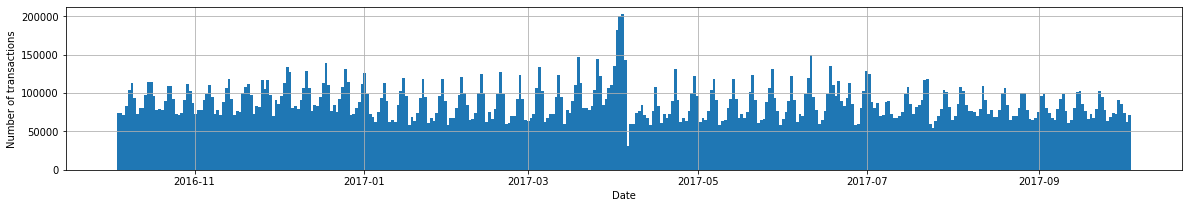

In [9]:
# Нарисуем распределение транзакция по времени
df['chq_date'].hist(figsize = (20, 3), bins = df['chq_date'].nunique())
plt.xlabel('Date')
plt.ylabel('Number of transactions')

### Добавим несколько колонок, которые помогут потом

In [10]:
%%time

# Колонка количество товаров в транзакции (с учетом дубликатов)
dct = df.groupby('chq_id')['sales_count'].sum().to_dict()
df['chq_id_sum_sales_count'] = df['chq_id'].apply(lambda x:dct[x])

# Колонка количество товаров в транзакции (без учетом дубликатов)
dct = df.groupby('chq_id').apply(len).to_dict()
df['chq_id_len'] = df['chq_id'].apply(lambda x:dct[x])

# Сумма sales_sum товров в транзакции
dct = df.groupby('chq_id')['sales_sum'].sum().to_dict()
df['chq_id_sum_sales_sum'] = df['chq_id'].apply(lambda x:dct[x])

CPU times: user 2min 1s, sys: 5.42 s, total: 2min 7s
Wall time: 2min 6s


In [11]:
df.head(10)

,chq_id,plant,chq_date,chq_position,client_id,material,sales_count,sales_sum,is_promo,chq_id_sum_sales_count,chq_id_len,chq_id_sum_sales_sum
0,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,004,90fca68123e692a005a4edeadd94b2f2,232cfe8b28970434f685b737737b26d4,2.000,146.98,0,17.728,13,1634.0
1,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,003,90fca68123e692a005a4edeadd94b2f2,12ec64451b8e426db16f3f05ea770901,1.000,249.99,1,17.728,13,1634.0
2,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,012,90fca68123e692a005a4edeadd94b2f2,1212ff8ecf53aebef093ca8ae216db68,1.000,47.99,1,17.728,13,1634.0
3,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,013,90fca68123e692a005a4edeadd94b2f2,1212ff8ecf53aebef093ca8ae216db68,1.000,47.99,1,17.728,13,1634.0
4,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,011,90fca68123e692a005a4edeadd94b2f2,571c6d3b559db8445e05265649eb30ab,2.000,53.98,1,17.728,13,1634.0
5,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,001,90fca68123e692a005a4edeadd94b2f2,76608b1b1d38384fcac3e2b14e6ec0c9,2.000,64.78,1,17.728,13,1634.0
6,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,006,90fca68123e692a005a4edeadd94b2f2,86069eddeab2b94b00eca5801628c879,0.728,65.51,0,17.728,13,1634.0
7,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,010,90fca68123e692a005a4edeadd94b2f2,cd8645ab842a98332560a07d137aed24,1.000,36.99,1,17.728,13,1634.0
8,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,007,90fca68123e692a005a4edeadd94b2f2,f6f07df28266b03cb7822b62abf0a385,2.000,72.99,1,17.728,13,1634.0
9,ce5b3d1c531348c5d0d8e859b6d0cf91,7cd86ecb09aa48c6e620b340f6a74592,2016-11-01,005,90fca68123e692a005a4edeadd94b2f2,b726b2ec8d0643d38e29d96733153dd4,2.000,51.98,1,17.728,13,1634.0


In [12]:
%%time
# Создаем различные варианты агрегаций времени

# Месяц
df['chq_date(month)']       = pd.to_datetime(df['chq_date'].dt.strftime('%Y.%m'))

# Неделя
df['chq_date(week)']        = df['chq_date'].apply(lambda dt: dt - timedelta(days=dt.weekday()))

# День недели
day_of_week_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['chq_date[day_of_week]'] = df['chq_date'].dt.dayofweek#.apply(lambda x:day_of_week_list[x])

CPU times: user 15min 55s, sys: 16.7 s, total: 16min 12s
Wall time: 16min 11s


In [13]:
# Данные идут всегда через день?
# > Да, равномерно через день
set(np.diff(sorted(df["chq_date"].unique())))

{numpy.timedelta64(86400000000000,'ns')}

### Графики зависимости от времени

In [14]:
%%time
#### Построем всякие различные графики по времени
# построим таблицу, проиндексированную по датам, сохранив ее
# len - число строк для данной даты в исх. таблице
# user_unique - число уникальных клиентов в день
# transaction_unique - число уникальнных транзакций в день
# sales_sum - за день продано на такую сумму
# sales_count - число проданных товаров
# average_sum - средняя сумма транзы в день
# material - число уникальных товаров, которые были проданы в этот день
# is_promo_sum - суммарное число проданных промо товаров в день
# is_promo_per_trans - среднее число проданных по промо товаров на транзакцию в этот день
# is_promo_sales_sum_sum - общая стоимость проданных по промо товаров
# is_promo_sales_sum_mean - общая сумма купленного по промо по отношению к общей сумме проданного в день
#unique_plant - число магазинов, в которых что-то было продано в этот день

def get_time_features(data):
    res = {'len' : len(data),
           'user_unique': data['client_id'].nunique(),
           'transaction_unique':data['chq_id'].nunique(),
           'sales_sum':data['sales_sum'].sum(),
           'sales_count':data['sales_count'].sum(),
           'average_sum':data['sales_sum'].mean(),
           'material':data['material'].nunique(),
           'is_promo_sum':data['is_promo'].sum(),
           'is_promo_per_trans':data['is_promo'].mean(),
           'is_promo_sales_sum_sum':data.loc[data['is_promo']==1, 'sales_sum'].sum(),
           'is_promo_sales_sum_mean':data.loc[data['is_promo']==1, 'sales_sum'].sum()/data['sales_sum'].sum(),
           'unique_plant':data['plant'].nunique()
          }
    return pd.Series(res)

df_stat = df.groupby('chq_date').apply(get_time_features)
df_stat.to_csv(r'df_stat.csv')

CPU times: user 35.1 s, sys: 3.06 s, total: 38.2 s
Wall time: 38.2 s


#### По дням

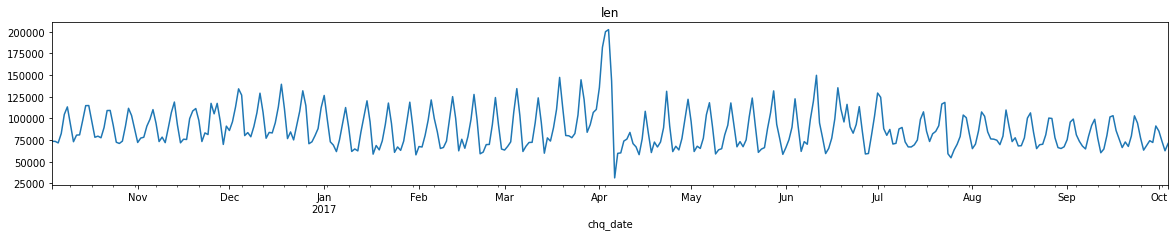

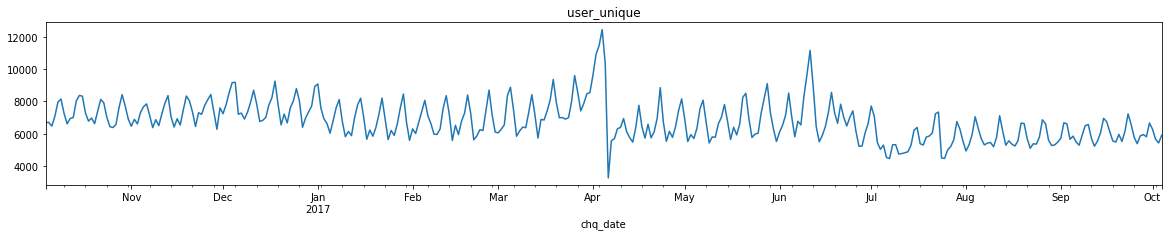

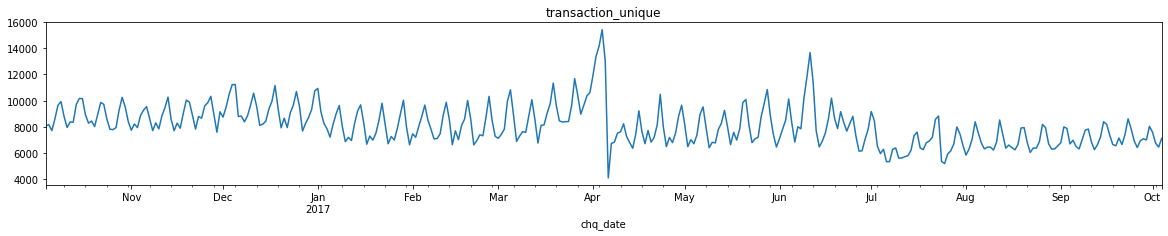

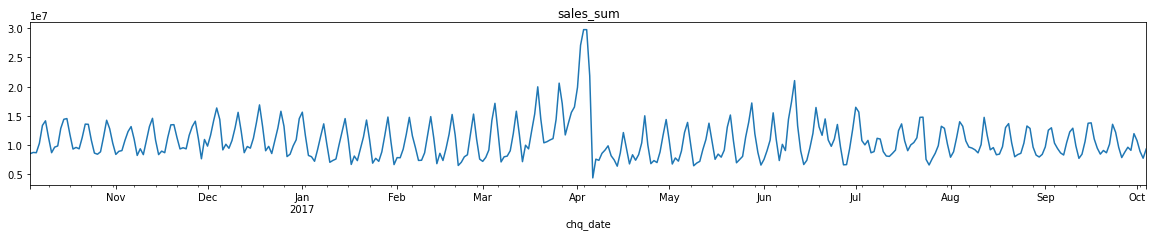

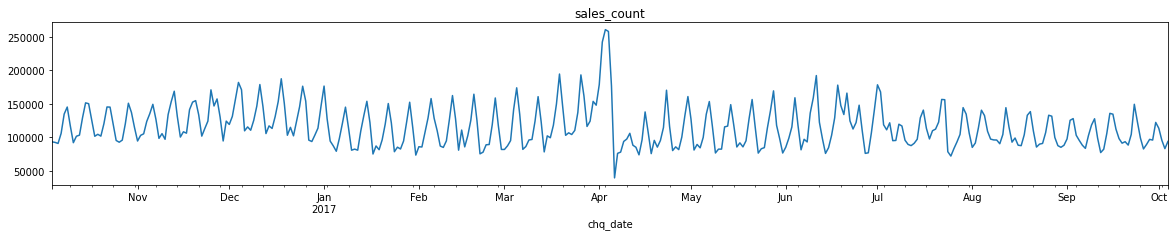

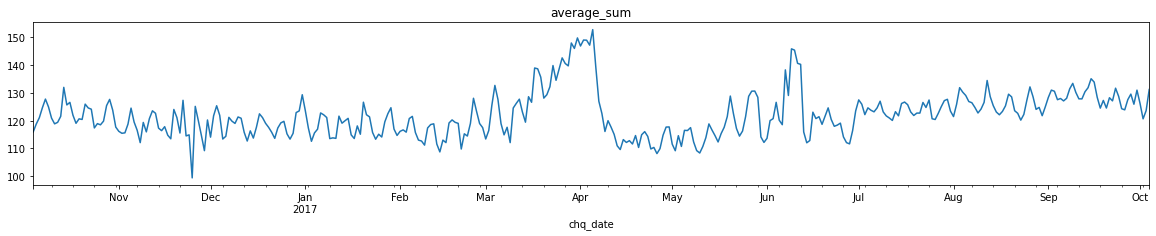

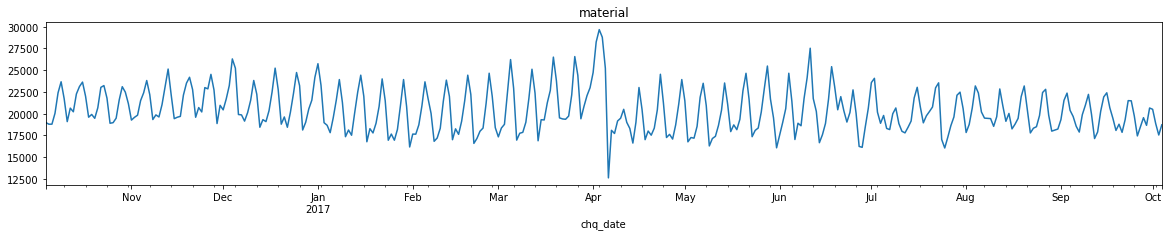

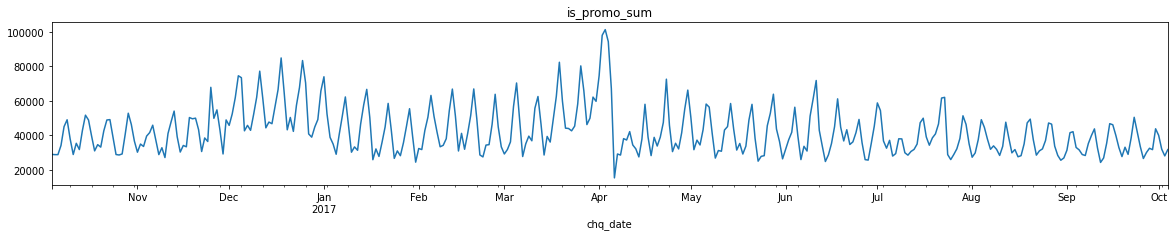

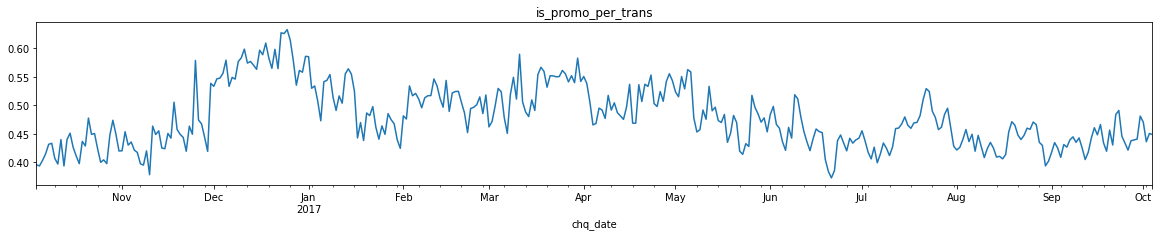

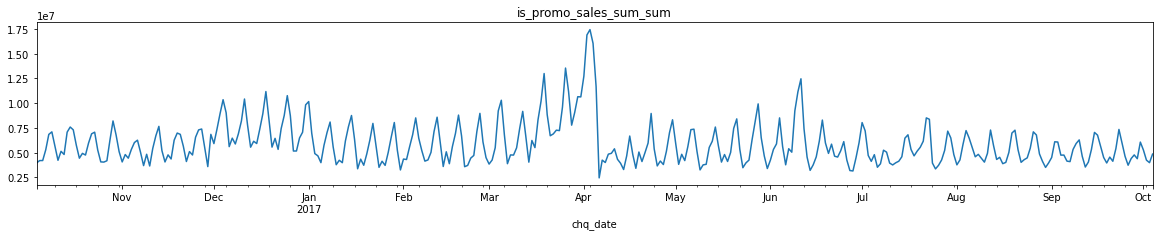

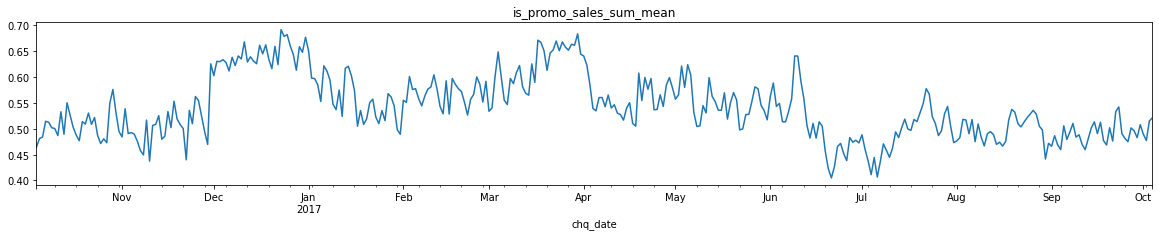

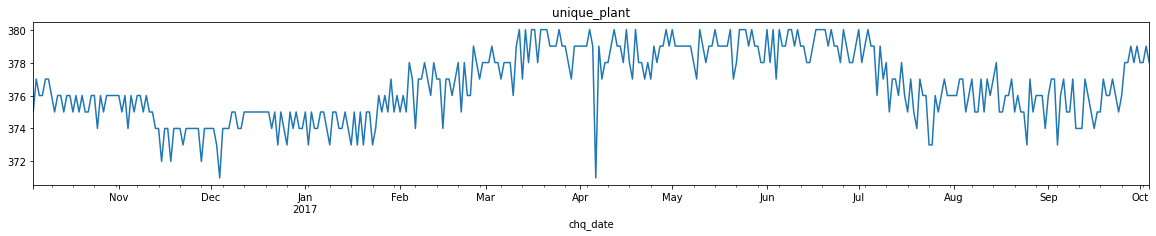

In [15]:
## Подневно
for key in df_stat.keys():
    df_stat[key].plot(figsize = (20, 3), title = key)
    #df_stat[key][-140-7*12:-112-7*12].reset_index(drop=True).plot(figsize = (20, 3), title = key)


    plt.show()
    
# есть сильная зависимость по дням
# по выходным на 50-70% лучше чем на неделе

# сезонной ззависимости мало

# есть небольшой общий тренд на понижение

# в апреле что-то случилось

In [16]:
#возле апреля интересно поведени графика average sum - средняя сумма транзакции росла в теч. месяца до странного события
#это могло бы объяснить некоторые графики, но не уникальное число покупателей в день - user_unique
#т.е. ближе к апрелю росло число покупателей И их средний чек
#конец какой-то скидочной программы? если и так, то это не промо-товары из таблицы: доля промо товаров в чеке и доля промо в проданном 
#не росли, подходя к рассматриваемой точке
#возможно, другая бонусная программа

In [17]:
# %%time
# # Создаем различные варианты агрегаций времени

# # Месяц
# df['chq_date(month)']       = pd.to_datetime(df['chq_date'].dt.strftime('%Y.%m'))

# # Неделя
# df['chq_date(week)']        = df['chq_date'].apply(lambda dt: dt - timedelta(days=dt.weekday()))

# # День нелели
# day_of_week_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# df['chq_date[day_of_week]'] = df['chq_date'].dt.dayofweek#.apply(lambda x:day_of_week_list[x])

#### По месяцам

In [18]:
# df['chq_date(month)d'].nunique()

Графики по месяцам


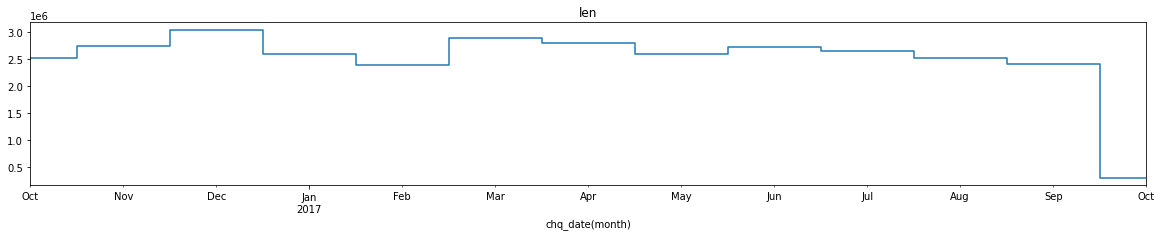

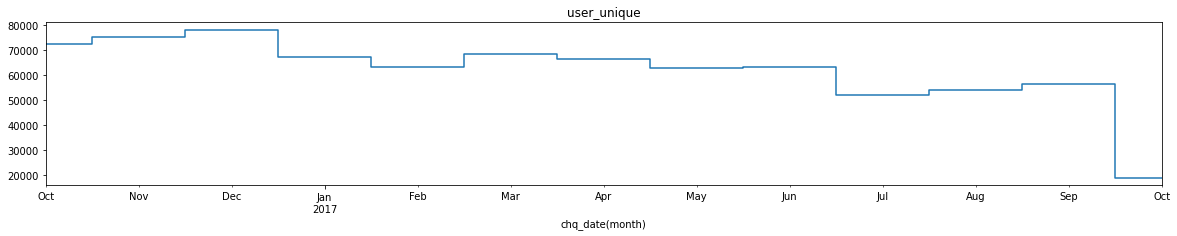

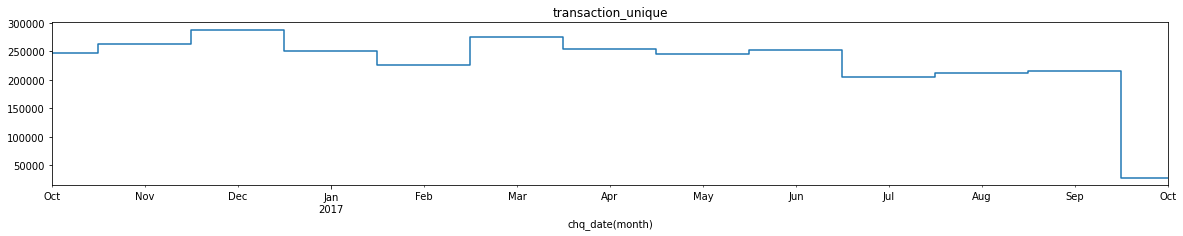

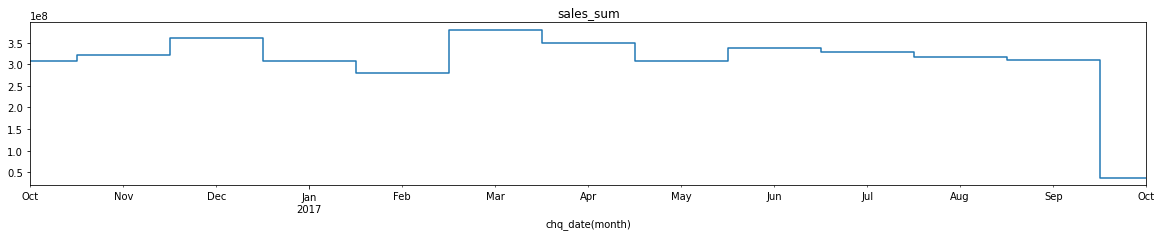

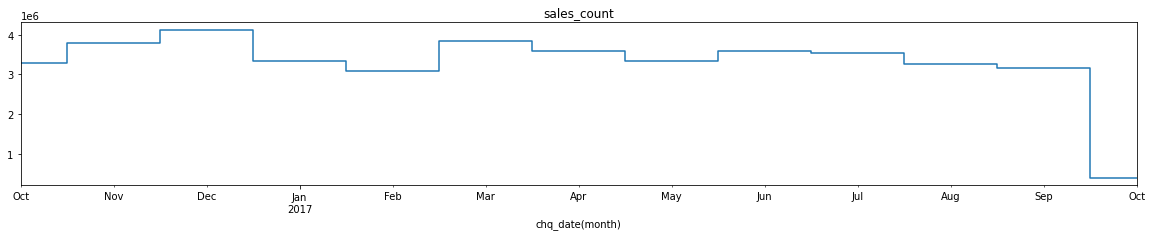

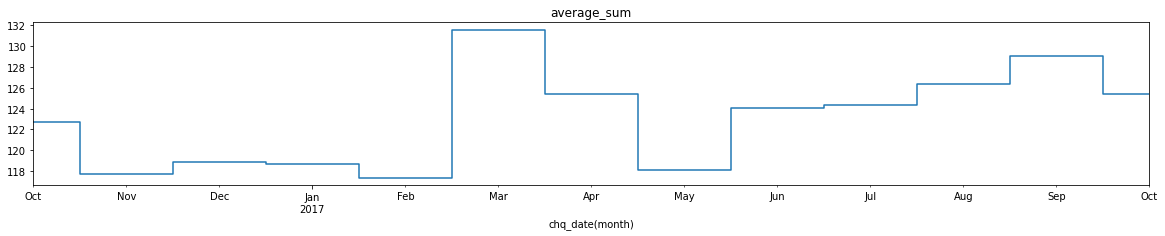

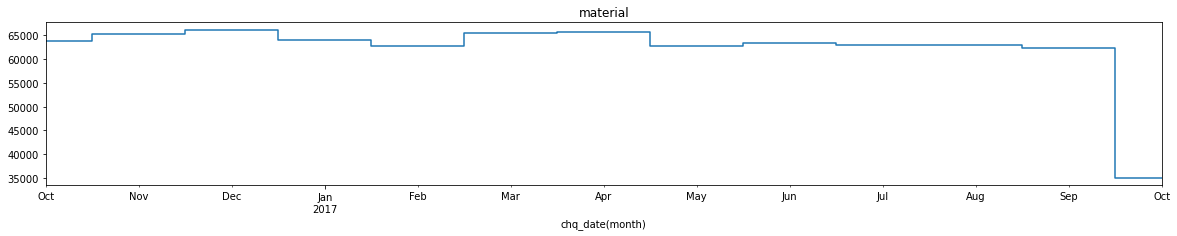

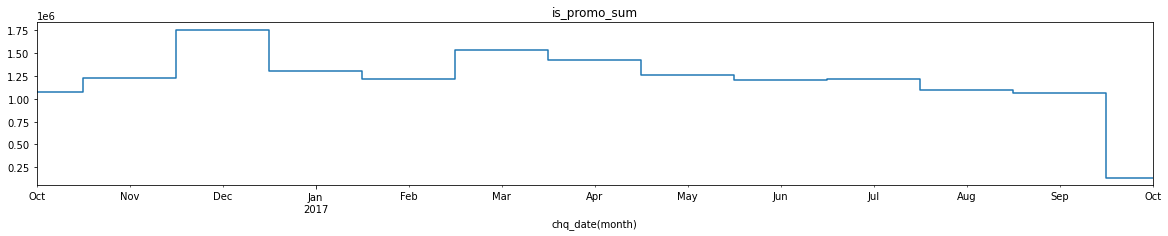

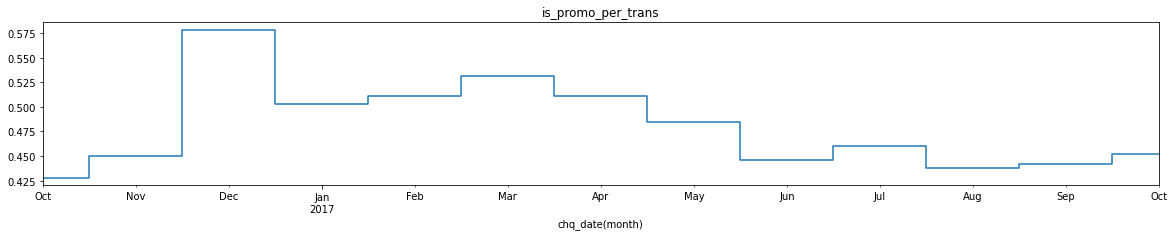

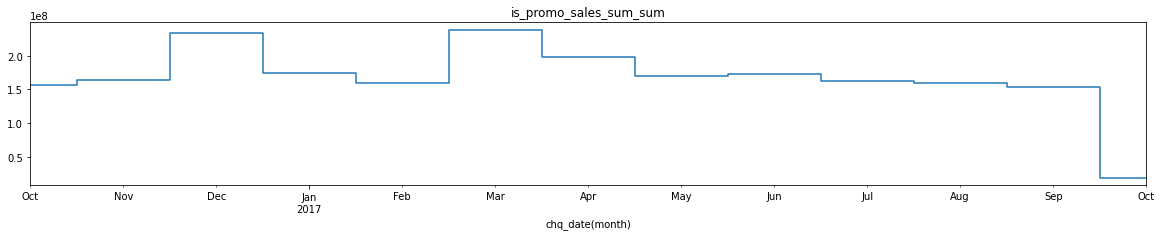

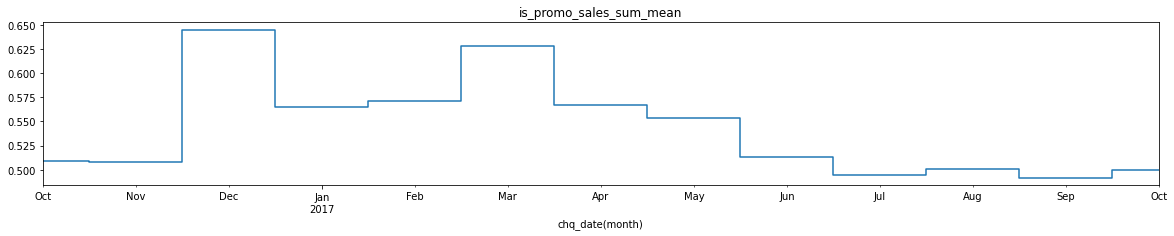

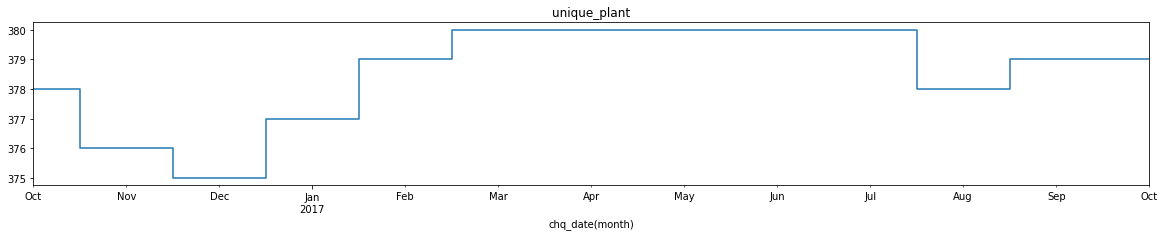

CPU times: user 6min 29s, sys: 6.55 s, total: 6min 36s
Wall time: 6min 35s


In [19]:
%%time
# # Создаем различные варианты агрегаций времени
# # Месяц

df['chq_date(month)'] = pd.to_datetime(df['chq_date'].dt.strftime('%Y.%m'))

print('Графики по месяцам')
df_temp = df.groupby('chq_date(month)').apply(get_time_features)
## Подневно
for key in df_temp.keys():
    df_temp[key].plot(figsize = (20, 3), 
                      title = key, 
                      drawstyle ="steps-mid")
    plt.show()

#### По дням недели

Графики по неделям


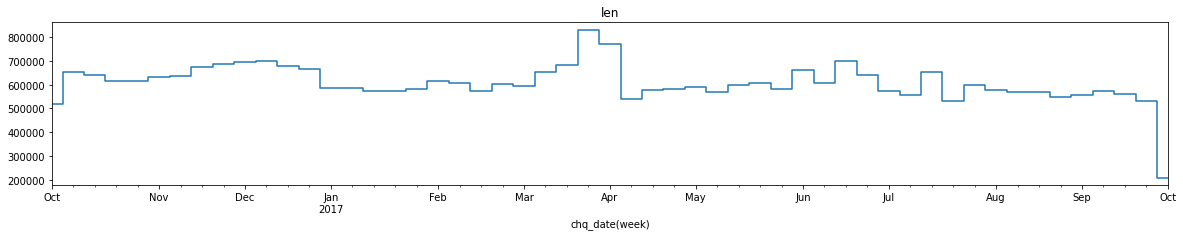

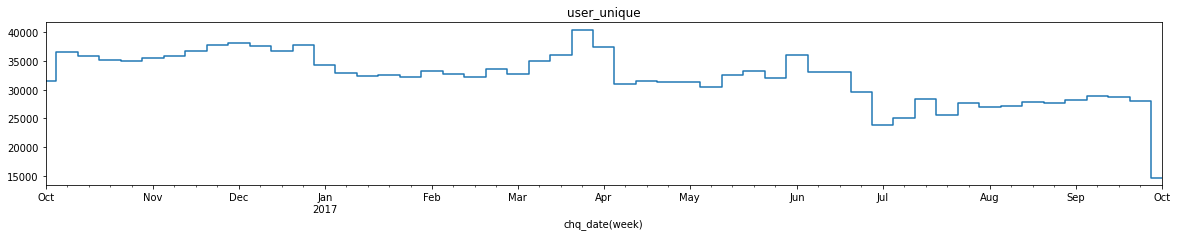

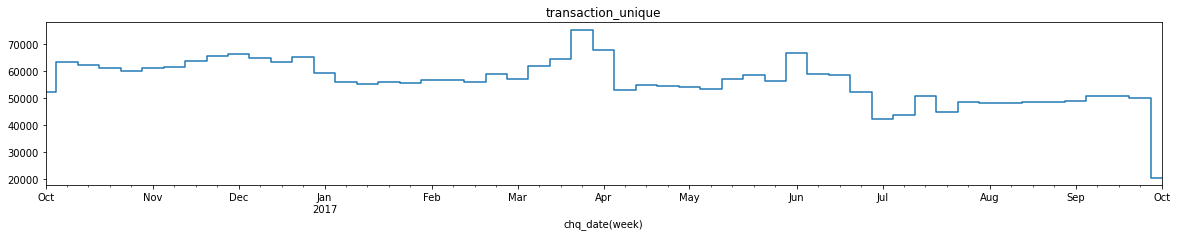

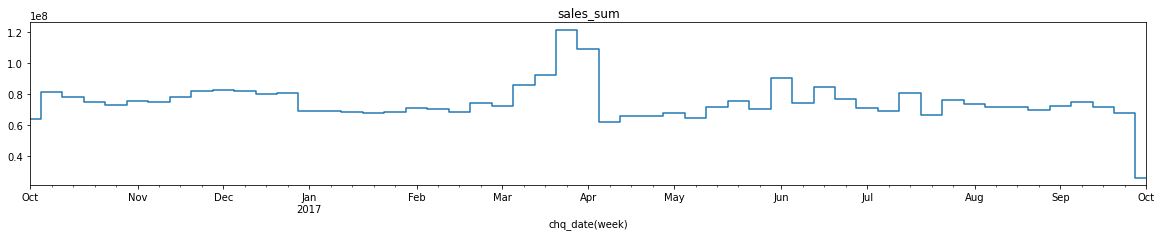

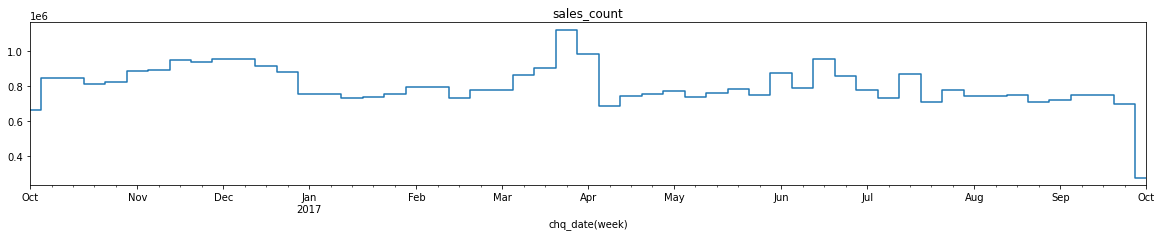

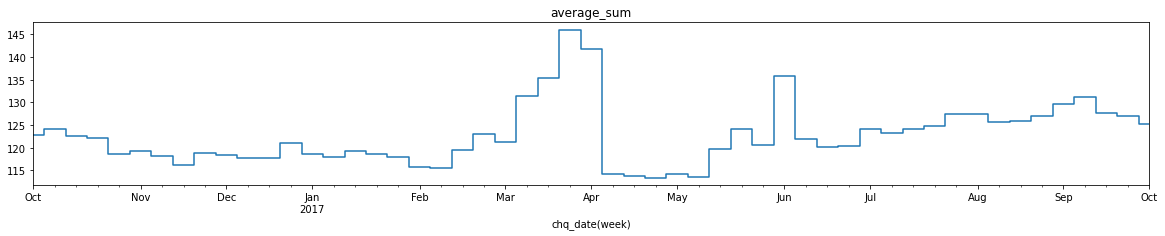

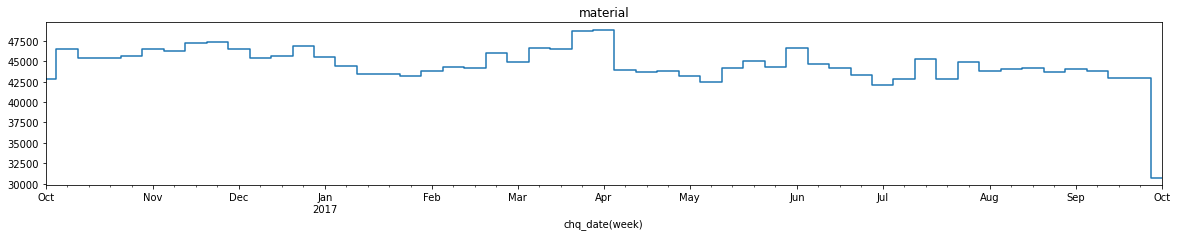

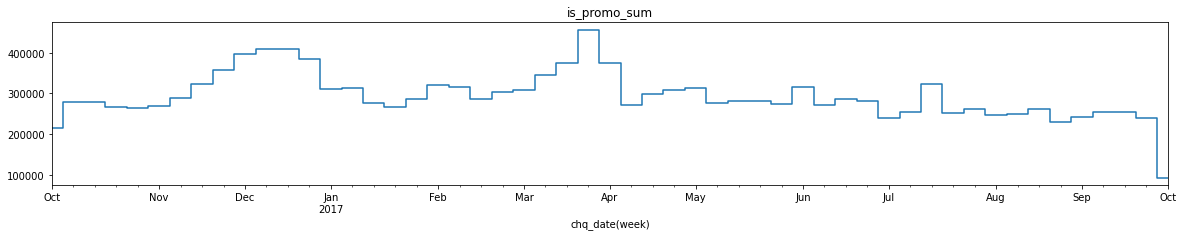

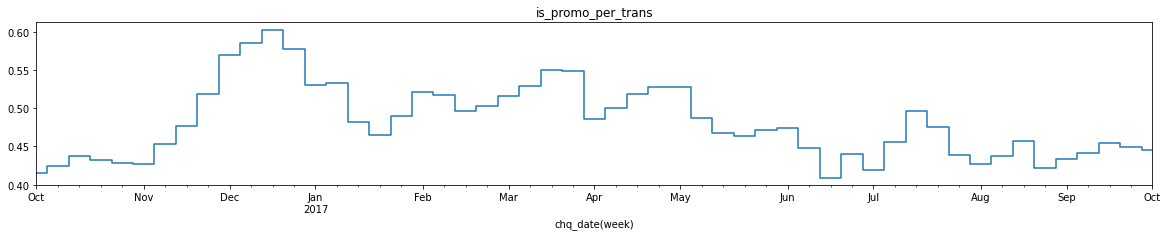

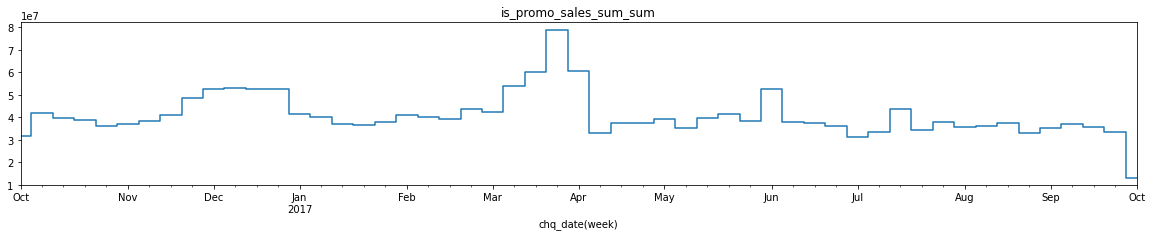

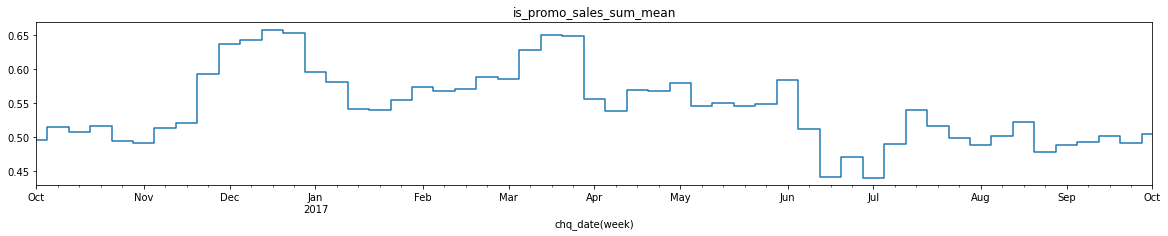

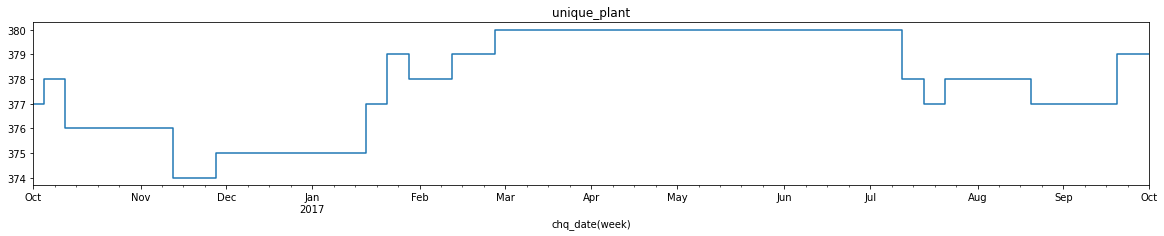

CPU times: user 9min 17s, sys: 13 s, total: 9min 30s
Wall time: 9min 30s


In [20]:
%%time
# Создаем различные варианты агрегаций времени
# Неделя

df['chq_date(week)'] = df['chq_date'].apply(lambda dt: dt - timedelta(days=dt.weekday()))

print('Графики по неделям')
df_temp = df.groupby('chq_date(week)').apply(get_time_features)
## Подневно
for key in df_temp.keys():
    df_temp[key].plot(figsize = (20, 3), 
                      title = key,
                      drawstyle ="steps-mid")
    plt.show()

#### По дням недели (понедельник, вторник, )

Графики по дням недели


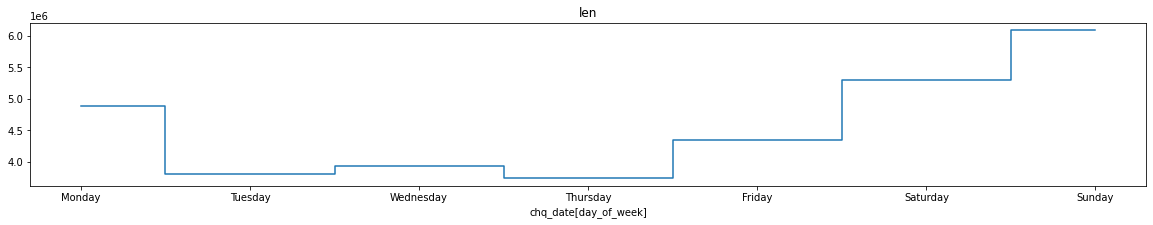

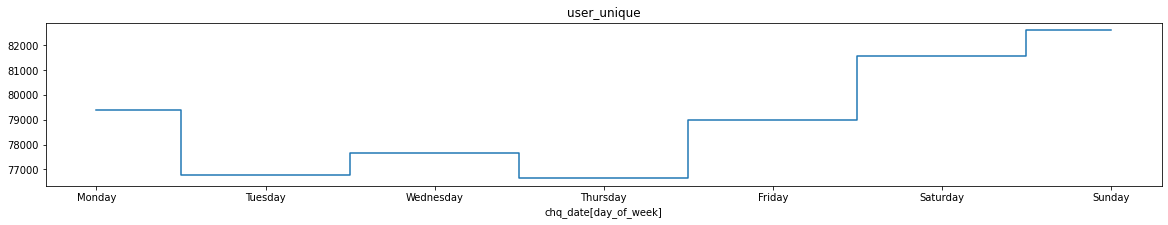

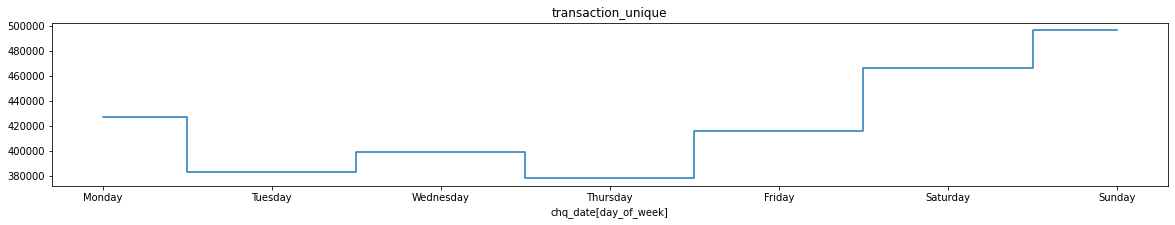

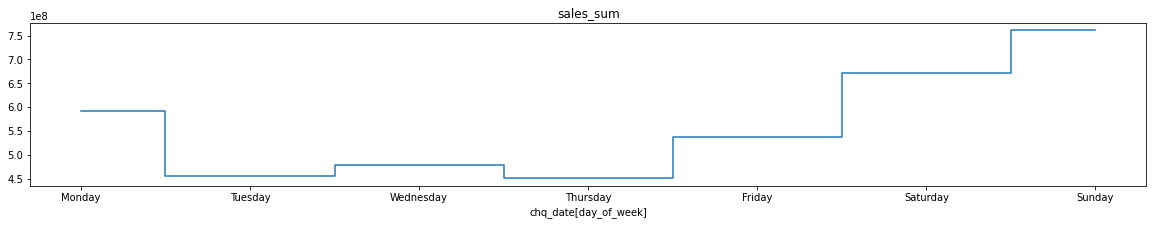

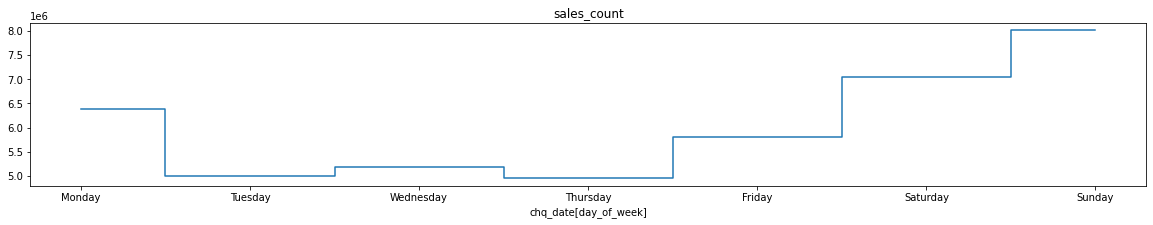

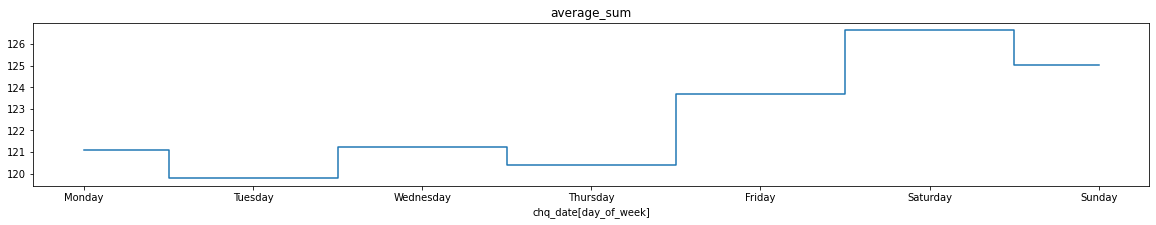

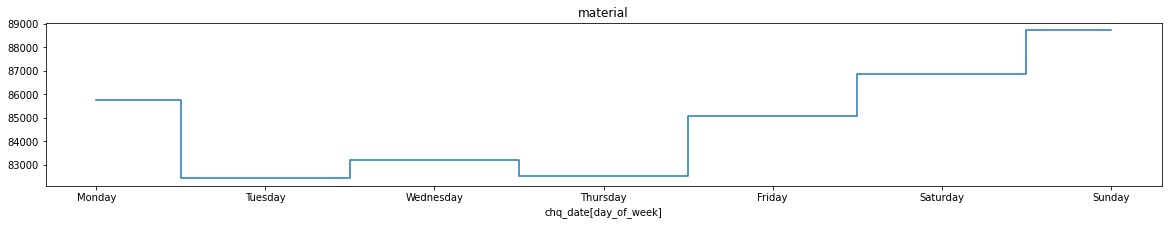

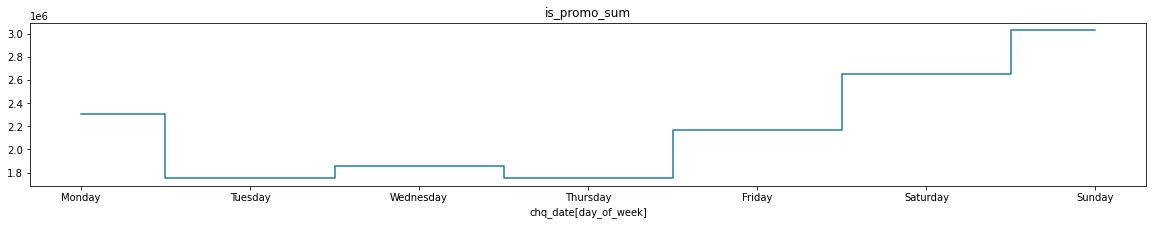

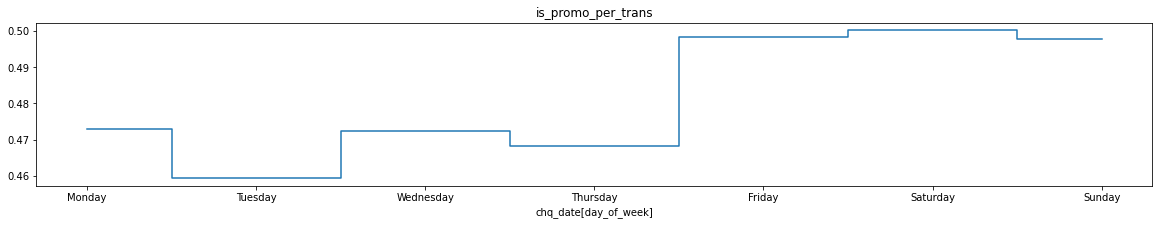

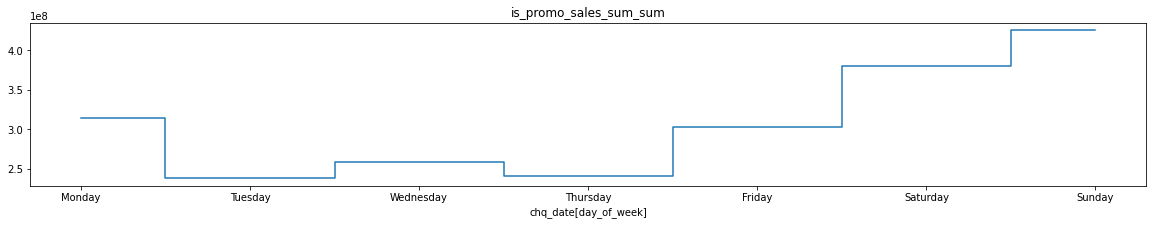

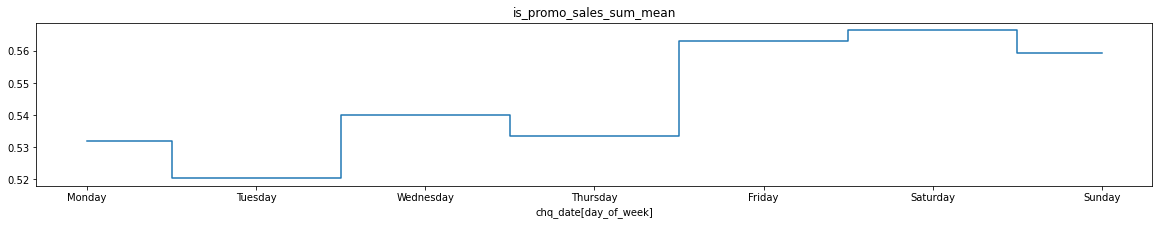

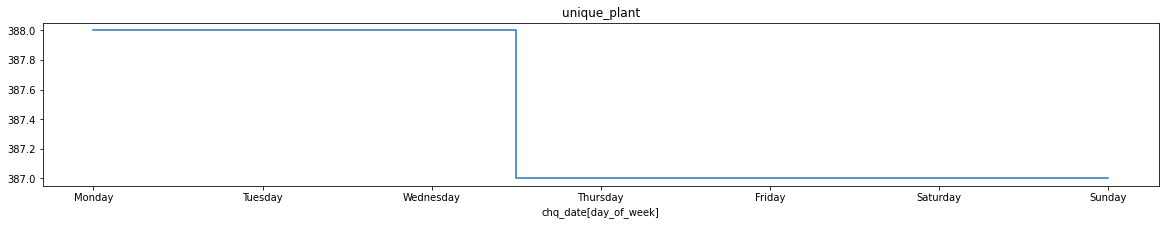

CPU times: user 34.2 s, sys: 3.15 s, total: 37.4 s
Wall time: 37.3 s


In [21]:
%%time
# Создаем различные варианты агрегаций времени
# День нелели

day_of_week_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# df['chq_date[day_of_week]'] = df['chq_date'].dt.dayofweek#.apply(lambda x:day_of_week_list[x])
print('Графики по дням недели')
df_temp = df.groupby('chq_date[day_of_week]').apply(get_time_features)
## Подневно
for key in df_stat.keys():
    df_temp[key].plot(figsize = (20, 3), 
                      title = key, 
                      drawstyle ="steps-mid"
                     )
    
    plt.xticks(range(0, len(day_of_week_list)), day_of_week_list)
    plt.show()

### Выручка по магазинам на начало и на конец периода

In [22]:
def draw2plot(l1 = "2017-01-01",
              r1 = "2017-02-01",
              l2 = "2017-03-01",
              r2 = "2017-04-01", 
              name_str = "sales_sum"
             ):

    l = pd.to_datetime(l1)
    r = pd.to_datetime(r1)

    df0 = df[(df['chq_date']<r) & (df['chq_date']>l) ]

    l = pd.to_datetime(l2)
    r = pd.to_datetime(r2)


    df1 = df[(df['chq_date']<r) & (df['chq_date']>l) ]

    a = df0.groupby('plant')[[name_str]].sum().sort_values(name_str, ascending = False).rename(columns = {name_str:'first'})#.reset_index()
    b = df1.groupby('plant')[[name_str]].sum().sort_values(name_str, ascending = False).rename(columns = {name_str:'last'})#.reset_index()

    print(f"Number of stores 1: {len(a)}, 2: {len(b)}")
    
    df_store_stat = pd.merge(a, 
                             b, 
                             how = 'outer',
                             on  = 'plant')

    plt.figure(figsize = (10, 10))
    plt.scatter(df_store_stat['first'], df_store_stat['last'])
    t = max(df_store_stat['first'])
    plt.plot([0, t], [0, t], color = 'red', linestyle = '--', linewidth = 5, alpha = 0.5)
    plt.title(f'{name_str} sum', size = 22)
    plt.ylabel(f'last  month [{l1};{r1}]', size = 18)
    plt.xlabel(f'first month [{l2};{r2}]', size = 18)
    plt.show()


Number of stores 1: 377, 2: 380


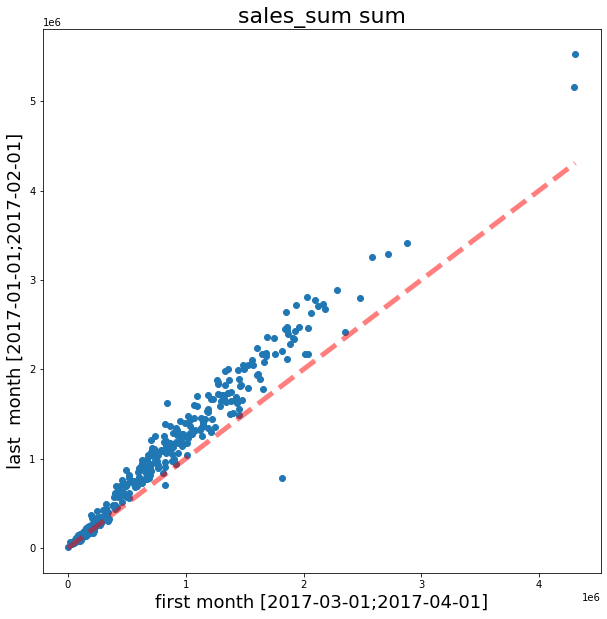

In [23]:
draw2plot(l1 = "2017-01-01",
          r1 = "2017-02-01",
          l2 = "2017-03-01",
          r2 = "2017-04-01")

Number of stores 1: 380, 2: 380


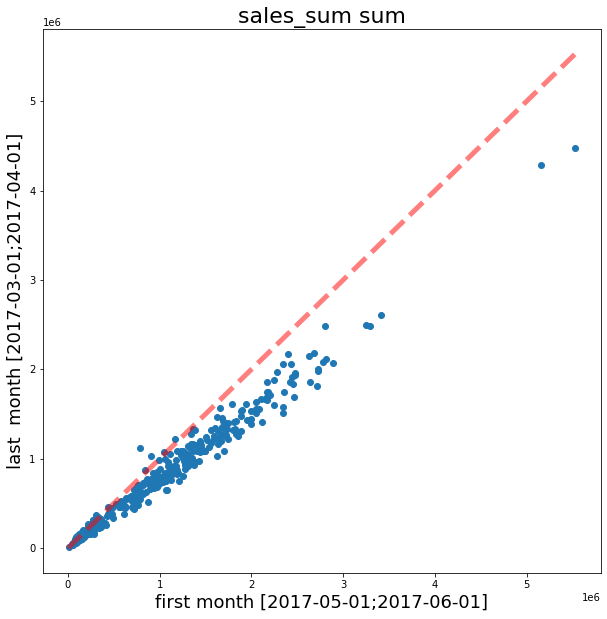

In [24]:
draw2plot(l1 = "2017-03-01",
          r1 = "2017-04-01",
          l2 = "2017-05-01",
          r2 = "2017-06-01")

Number of stores 1: 385, 2: 383


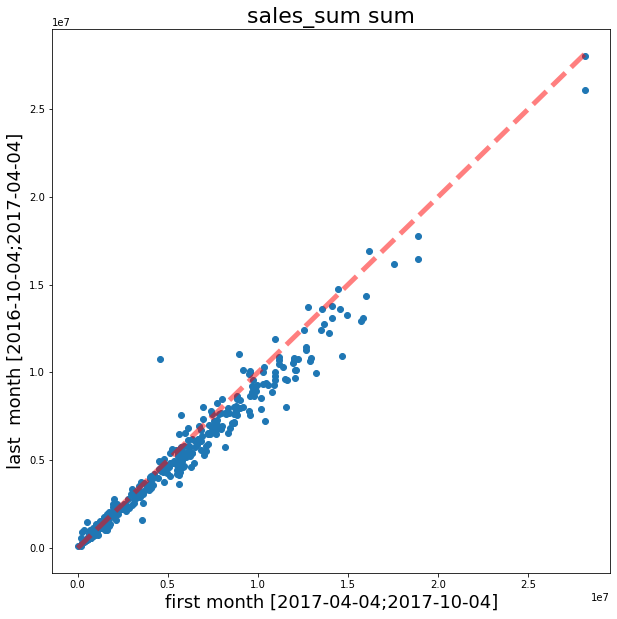

In [25]:
draw2plot(l1 = "2016-10-04",
          r1 = "2017-04-04",
          l2 = "2017-04-04",
          r2 = "2017-10-04")

#### Странно, но в выборке есть негативные транзакции

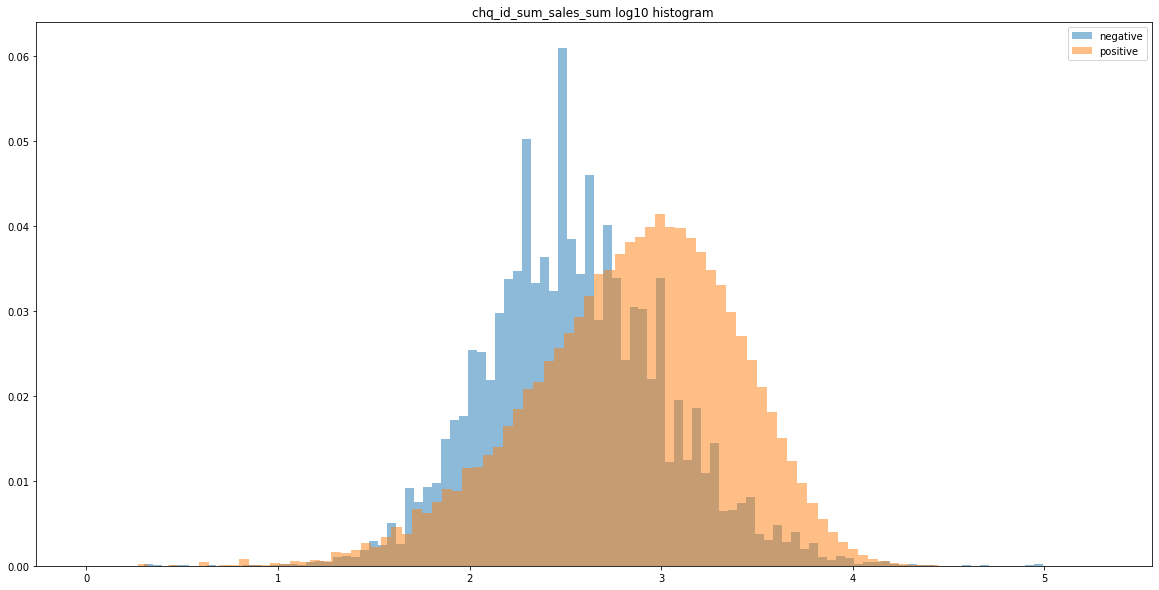

In [26]:
o = df.drop_duplicates('chq_id')
plt.figure(figsize = (20, 10))
o_current = o.loc[o['chq_id_sum_sales_sum']<0, 'chq_id_sum_sales_sum'].apply(lambda x:np.log10(1-x))
w = np.ones(len(o_current))/len(o_current)
plt.hist(o_current, weights=w, bins = 100, label = 'negative', alpha = 0.5)
plt.title('chq_id_sum_sales_sum log10 histogram ')

o_current = o.loc[o['chq_id_sum_sales_sum']>=0, 'chq_id_sum_sales_sum'].apply(lambda x:np.log10(1+x))
w = np.ones(len(o_current))/len(o_current)
plt.hist(o_current, weights=w, bins = 100, label = 'positive', alpha = 0.5)
plt.legend()
plt.show()

# В логарифмических осях построить распределение chq_id_sum_sales_sum, должно выйти лог-нормальное распределение

> Возможно это омена покупки?

Кстати средний чек около 1000 руб

### Как выглядят сумма положительных и отрицательных чеков по дням

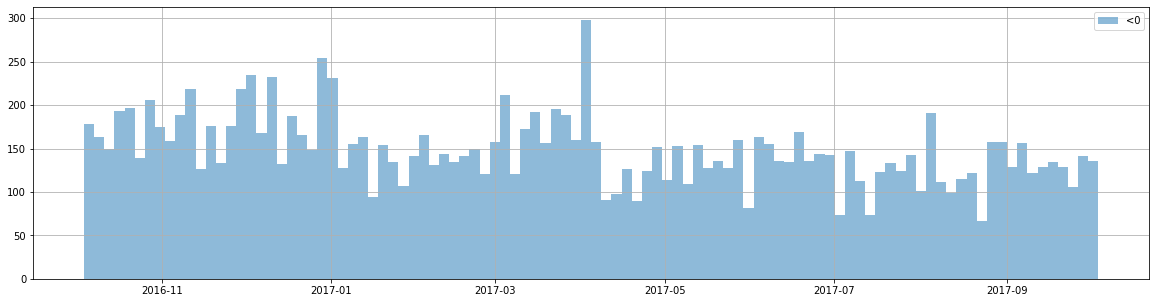

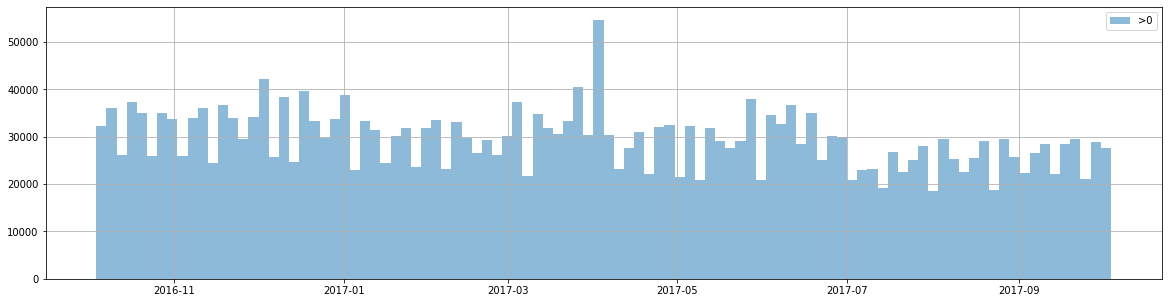

In [27]:
df.loc[df['chq_id_sum_sales_sum']<0].drop_duplicates('chq_id')['chq_date'].hist(label = '<0', figsize = (20, 5), alpha = 0.5, bins = 100)
plt.legend()
plt.show()

df.loc[df['chq_id_sum_sales_sum']>=0].drop_duplicates('chq_id')['chq_date'].hist(label = '>0', figsize = (20, 5),alpha = 0.5, bins = 100)
plt.legend()
plt.show()

In [28]:
# Правда ли, что нет транзакций в которых есть и отрицательные и положительные чеки?
# Проверим что это отмена
print('<0 correct', (df.loc[df['chq_id_sum_sales_sum']<0, 'sales_sum']<0).all())
print('>0 correct', (df.loc[df['chq_id_sum_sales_sum']>0, 'sales_sum']>0).all())
# > Да

<0 correct True
>0 correct True


In [29]:
df.loc[df['chq_id_sum_sales_sum']<0].sort_values('chq_id_sum_sales_sum')

,chq_id,plant,chq_date,chq_position,client_id,material,sales_count,sales_sum,is_promo,chq_id_sum_sales_count,chq_id_len,chq_id_sum_sales_sum,chq_date(month),chq_date(week),chq_date[day_of_week]
31431694,61b17e3843e880f6bd51324a8d94610e,c81c2b9e997a81f84838cd8e60b93a01,2016-10-21,001,596f837a638189cb15e9d4b144dd45c4,df61ac05dd83388e5b5c766cf4fcb312,-60.0,-98388.00,0,-60.0,1,-98388.00,2016-10-01,2016-10-17,4
31431709,cc50070834892c5348978d9d3f3c9cb5,c81c2b9e997a81f84838cd8e60b93a01,2016-10-21,003,596f837a638189cb15e9d4b144dd45c4,639744133763da589ad3055d293b9154,-48.0,-34236.00,0,-120.0,3,-95251.00,2016-10-01,2016-10-17,4
31431699,cc50070834892c5348978d9d3f3c9cb5,c81c2b9e997a81f84838cd8e60b93a01,2016-10-21,002,596f837a638189cb15e9d4b144dd45c4,ec13cc81075855dfe31e2fb8116344ed,-4.0,-3389.76,0,-120.0,3,-95251.00,2016-10-01,2016-10-17,4
31431690,cc50070834892c5348978d9d3f3c9cb5,c81c2b9e997a81f84838cd8e60b93a01,2016-10-21,001,596f837a638189cb15e9d4b144dd45c4,ec13cc81075855dfe31e2fb8116344ed,-68.0,-57625.24,0,-120.0,3,-95251.00,2016-10-01,2016-10-17,4
31431703,af2b422068ed54af49ef0275520314a7,c81c2b9e997a81f84838cd8e60b93a01,2016-10-21,003,596f837a638189cb15e9d4b144dd45c4,df61ac05dd83388e5b5c766cf4fcb312,-10.0,-16398.00,0,-100.0,3,-94689.00,2016-10-01,2016-10-17,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17187510,113e16efd4d3653ea360ba14fab7c1e0,56c66132e67551c55b1667f9b14de886,2017-04-05,001,18b4bee65b54e69f28ec71c4e49660d2,e157c57ca48445c18680a86767f4c997,-1.0,-1.37,1,-1.0,1,-1.37,2017-04-01,2017-04-03,2
28010290,caba8f8f97354ffaaccf5d9ff9a42a92,2ebe25dd3a566f36f80d55440d3c3834,2017-08-19,001,806aa67e23892d029172d4347da3310a,d24abc923a61543ffc13ccace7cb5da4,-1.0,-1.00,1,-1.0,1,-1.00,2017-08-01,2017-08-14,5
28241201,83549160c46d0cabdea5abdf7ee7171b,2d0974b2436345d99f7152c3fc44a609,2017-08-25,001,d3b66ff3c56a962b5b4146d46a6940be,d3e97c413ab082ba9e5fe06d053e9f25,-1.0,-1.00,0,-1.0,1,-1.00,2017-08-01,2017-08-21,4
14176442,f50e725f14a879adb1d173467f4cf560,62a8d042a93d5f88fb6636cde700ce69,2017-04-04,001,35be5e61ba319475211d55cd64ffcc5e,cfe5b2573c75bb74848a1ae7da2e628a,-1.0,-1.00,1,-1.0,1,-1.00,2017-04-01,2017-04-03,1


#### Если это отмена, попробуем найти отмененные покупки в базе

In [30]:
df.loc[df['chq_id_sum_sales_sum']<0]["chq_id_sum_sales_sum"].value_counts()

-300.00      99
-199.00      85
-7211.00     80
-99.99       78
-23036.00    78
             ..
-141.26       1
-1998.84      1
-848.31       1
-155.29       1
-812.35       1
Name: chq_id_sum_sales_sum, Length: 10611, dtype: int64

In [31]:
df.loc[df['chq_id_sum_sales_sum']==-1.37]

,chq_id,plant,chq_date,chq_position,client_id,material,sales_count,sales_sum,is_promo,chq_id_sum_sales_count,chq_id_len,chq_id_sum_sales_sum,chq_date(month),chq_date(week),chq_date[day_of_week]
17187510,113e16efd4d3653ea360ba14fab7c1e0,56c66132e67551c55b1667f9b14de886,2017-04-05,001,18b4bee65b54e69f28ec71c4e49660d2,e157c57ca48445c18680a86767f4c997,-1.0,-1.37,1,-1.0,1,-1.37,2017-04-01,2017-04-03,2


In [32]:
df.loc[df['chq_id_sum_sales_sum']==1.37]

,chq_id,plant,chq_date,chq_position,client_id,material,sales_count,sales_sum,is_promo,chq_id_sum_sales_count,chq_id_len,chq_id_sum_sales_sum,chq_date(month),chq_date(week),chq_date[day_of_week]


##### Нет повнота, скорее всего наше предположение не верно, попробуем еще раз позже

In [33]:
df.loc[df['chq_id_sum_sales_sum']==-112]

,chq_id,plant,chq_date,chq_position,client_id,material,sales_count,sales_sum,is_promo,chq_id_sum_sales_count,chq_id_len,chq_id_sum_sales_sum,chq_date(month),chq_date(week),chq_date[day_of_week]
825990,7ffda6e6cc1bec49b4547bbece727405,6296580f0889e341dd9ba0992333171d,2016-11-29,001,acbddf27bbb1c126812778a31be6f899,53e12736b59eb0964e1d14d7cdabcded,-0.28,-112.0,0,-0.28,1,-112.0,2016-11-01,2016-11-28,1


In [34]:
df.loc[(df['chq_id_sum_sales_sum']==112) & (df['client_id']=='acbddf27bbb1c126812778a31be6f899')]

,chq_id,plant,chq_date,chq_position,client_id,material,sales_count,sales_sum,is_promo,chq_id_sum_sales_count,chq_id_len,chq_id_sum_sales_sum,chq_date(month),chq_date(week),chq_date[day_of_week]


> Странно, вернемся к этому вопросу позже

### Первчная подготовка признаков

In [35]:
%%time

def diff_to_days(x):
    return x / np.timedelta64(1, 's') / 60 / 60 / 24

def _get_features(data):
    data_no_duplicates = data.drop_duplicates("chq_id")
    data_negative      = data[data['sales_sum']<0]
    
    t_list = list(sorted(data_no_duplicates['chq_date'].unique()))
    deltas = diff_to_days(np.diff(t_list)) #интервалы между датами транзакций
    bins = [0, 1, 7, 14, 21, 28, 56, 112, 224, 448]
    res = {
           't_min'  : data['chq_date'].min(),          # Даты (первая, последняя и весь список)
           't_max'  : data['chq_date'].max(),  
           '_t_list' : t_list,
        
           'items_N' : data['chq_id'].nunique(),              # Количество пробитых товаров
           'items_sales_sum_sum':data['sales_sum'].sum(),     # Сколько потратил
           'items_sales_count_sum':data['sales_count'].sum(), # Сколько покупок сделал

           'items_N_negative' : data_negative['chq_id'].nunique(),              # Количество пробитых товаров
           'items_sales_sum_sum_negative':data_negative['sales_sum'].sum(),     # Сколько потратил
           'items_sales_count_sum_negative':data_negative['sales_count'].sum(), # Сколько покупок сделал
           
           "item_price_mean" : data['chq_id_sum_sales_count'].mean(), # Средняя цена товара
           "item_price_max"  : data['chq_id_len'].max(),              # Максимальная цена товара
           "item_price_min"  : data['chq_id_sum_sales_sum'].min(),    # Минимальная цена товара
           
        
           'chq_id_sum_sales_count_mean':data_no_duplicates['chq_id_sum_sales_count'].mean(),   # Средний количество покупок
           'chq_id_len_mean':data_no_duplicates['chq_id_len'].mean(),                           # Средее количнтво товаров
           'chq_id_sum_sales_sum_mean':data_no_duplicates['chq_id_sum_sales_sum'].mean(),       # Средняя цена товаров
                   
           'chq_id_sum_sales_count_min':data_no_duplicates['chq_id_sum_sales_count'].min(),  # То-же самое для минимума
           'chq_id_len_min':data_no_duplicates['chq_id_len'].min(),
           'chq_id_sum_sales_sum_min':data_no_duplicates['chq_id_sum_sales_sum'].min(),
            
           
           'chq_id_sum_sales_count_max':data_no_duplicates['chq_id_sum_sales_count'].max(), # То-же самое для максимума
           'chq_id_len_max':data_no_duplicates['chq_id_len'].max(),
           'chq_id_sum_sales_sum_max':data_no_duplicates['chq_id_sum_sales_sum'].max(),
        
           'promo_rate_count': (data['is_promo']==1).mean(),    # Доля промо
           'promo_rate_sales_sum': (data.loc[(data['is_promo']==1), 'sales_sum'].sum()+1)/(data['sales_sum'].sum()+1),
           'promo_rate_sales_count': (data.loc[(data['is_promo']==1), 'sales_count'].sum()+1)/(data['sales_count'].sum()+1),
        
            "delta_median" : np.median(deltas) if len(deltas)>0 else np.nan, # 
            "delta_min"    : np.min(deltas) if len(deltas)>0 else np.nan,
            "delta_max"    : np.max(deltas) if len(deltas)>0 else np.nan,
            "delta_std"    : np.std(deltas) if len(deltas)>0 else np.nan,
            "delta_moda"   : np.argmax(np.bincount(deltas.astype(int))) if len(deltas)>0 else np.nan,
          }
    
    # Позитивные транзакции
    res['items_N_positive']               = res['items_N']-res['items_N_negative']
    res['items_sales_sum_sum_positive']   = res['items_sales_sum_sum']-res['items_sales_sum_sum_negative']
    res['items_sales_count_sum_positive'] = res['items_sales_count_sum']-res['items_sales_count_sum_negative']
    
    
    # Отношение негативного к позитивному
    ##res['negative_pos_rate_len_positive'] = res['negative_pos_rate_len']  -res['negative_pos_rate_len_negative']  
    for l in range(1, len(bins)):
        res[f'delta_bin_{bins[l-1]}_{bins[l],}'] = np.mean([((bins[l-1]<=x) and (x<bins[l]))  for x in deltas])
    
    
    for c in range(2):
        res[f'plant_key_{c}'] = np.nan
        res[f'plant_val_{c}'] = np.nan 
        res[f'material_key_{c}'] = np.nan
        res[f'material_val_{c}'] = np.nan 
        
    # Самые популярные города по количеству и из доля
    for c, (key, val) in enumerate(data_no_duplicates['plant'].value_counts(True).to_dict().items()):
        if c>=2:
            break

        res[f'plant_key_{c}'] = key
        res[f'plant_val_{c}'] = val     
    #два топовых магазина для юзера
        
    # Самые популярные товары по количеству и из доля    
    for c, (key, val) in enumerate(data['material'].value_counts(True).to_dict().items()):
        if c>=2:
            break
            
        res[f'material_key_{c}'] = key
        res[f'material_val_{c}'] = val  
    
    # Добавить join на metrials из таблицы 'materials.txt'
    # Добавить join на plant из таблицы пользователей если для каждого магазина взять максимальное количество пользователей с городом, это должно помоч
    
    return pd.Series(res)  

# _get_features(df[:100])
# user_sample = ["1a47d62dddacc03fe90c15652f7ae1a4"]#df['client_id'].sample(5000, random_state = 42).to_numpy()
# res = df[df['client_id'].isin(user_sample)].groupby('client_id').apply(_get_features)
# res
df_client = df.groupby('client_id').apply(_get_features)
# df_client['client_id'] = df_client.index
# print('Finish calculating')

df_client.to_parquet("results/df_client_id.parquet")
# df_client

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.8/site-p

CPU times: user 19min 33s, sys: 8.9 s, total: 19min 42s
Wall time: 19min 40s


In [48]:
# res['chq_id_sum_sales_sum_mean']

In [37]:
df_client.head()

,t_min,t_max,_t_list,items_N,items_sales_sum_sum,items_sales_count_sum,items_N_negative,items_sales_sum_sum_negative,items_sales_count_sum_negative,item_price_mean,...,"delta_bin_112_(224,)","delta_bin_224_(448,)",plant_key_0,plant_val_0,material_key_0,material_val_0,plant_key_1,plant_val_1,material_key_1,material_val_1
client_id,,,,,,,,,,,,,,,,,,,,,
0000d48a8891cd462fdf01ea861ec53e,2016-10-31,2017-08-31,"[2016-10-31T00:00:00.000000000, 2016-11-20T00:...",40,85898.00,966.731,1,-249.00,-1.0,29.579307,...,0.0,0.0,6858fb45a3d3aef7c29322d3b68dffd1,0.625000,40f96e886f80e25f241b1781a2543157,0.037338,7f8bb0fe8b33780a08fe6b60ced14529,0.375000,254f1eba1181248807d128842b566bf9,0.032468
00028a1dcb30863404a386961a69300e,2016-10-09,2017-09-15,"[2016-10-09T00:00:00.000000000, 2016-10-20T00:...",34,51916.00,470.427,0,0.00,0.0,23.418793,...,0.0,0.0,585869cdf36ea981c9545fcfef880f1d,0.588235,b75147feae4cf8ec07fb5f2cef855def,0.059585,e7c1d363fdf4c85ee426f767361eabf9,0.205882,f659b68a28a0b9abf44d0d3467a8f949,0.020725
0004274683494a9eca5e70ef97299d55,2016-10-04,2017-10-04,"[2016-10-04T00:00:00.000000000, 2016-10-05T00:...",169,101130.00,1407.353,0,0.00,0.0,11.373868,...,0.0,0.0,5359c847ef4975cdc646e8be8cb5621f,0.644970,6eaa9bd12a43a4d79badd51a62ac3d76,0.055833,78c734ebceead5b7b07ffd1414b22eed,0.349112,8726f99aa703c86e77082909317187d9,0.036667
00072f81efcb3481861f7300c5e2a88a,2016-10-29,2017-09-07,"[2016-10-29T00:00:00.000000000, 2016-11-17T00:...",8,5125.00,44.596,0,0.00,0.0,8.663586,...,0.0,0.0,b03a75fccca587a511170aa5b7952210,1.000000,0f40df203ca44f40e44b07f57f90fa91,0.103448,NaN,NaN,5e3039a269ff005f2c76cea16c0cf783,0.068966
00076596eb749cf10c2e984621dffe95,2016-10-05,2017-10-04,"[2016-10-05T00:00:00.000000000, 2016-10-06T00:...",166,203833.46,3160.780,1,-249.54,-1.0,28.274646,...,0.0,0.0,47f91082e4cc7d6d0fcf49d5aa6f3711,0.987952,6278f48a43fb0a23036b3a11c92e726c,0.071996,2c393e45170ca8e02cc1b670e799da1b,0.012048,0e31ad075d99fab63be09dad89580d71,0.040206


In [38]:
# from collections import Counter
# lst = [i[1]  for i in df_client.index]
# Counter(lst)
# # np.array(df_client.index[:10])[-1]

In [39]:
# 5      - 2.89
# 50     - 2.77
# 5000   - 44 sec
# 100000 - 14 min

In [40]:
#     data_no_duplicates['plant']
# df[df['client_id'] == "90fca68123e692a005a4edeadd94b2f2"]['plant'].value_counts().to_dict()

In [41]:
df_client.sort_values('chq_id_sum_sales_count_mean')

,t_min,t_max,_t_list,items_N,items_sales_sum_sum,items_sales_count_sum,items_N_negative,items_sales_sum_sum_negative,items_sales_count_sum_negative,item_price_mean,...,"delta_bin_112_(224,)","delta_bin_224_(448,)",plant_key_0,plant_val_0,material_key_0,material_val_0,plant_key_1,plant_val_1,material_key_1,material_val_1
client_id,,,,,,,,,,,,,,,,,,,,,
f1a29ee132ae1f6d399c68c1e50f3d17,2016-10-23,2016-10-24,"[2016-10-23T00:00:00.000000000, 2016-10-24T00:...",2,0.0,0.000,1,-13498.0,-2.0,0.000000,...,0.000000,0.000000,d33f67c5652acb3fac99b9dc16bea0c1,1.000000,d5278668e76bbfeaf2f3697f8a9b0c54,0.500000,NaN,NaN,3697285cd0389b75c5f4949bec7f3b26,0.500000
1e383f2f798c9e134e7f6e48f9c0c40d,2016-10-14,2016-10-14,[2016-10-14T00:00:00.000000000],3,1750.0,1.000,1,-1750.0,-1.0,0.333333,...,NaN,NaN,8c5781246fcb0296e1f11cd4e2eee68d,1.000000,00f8076760d8b3f2b2505a66e7dbc2d9,1.000000,NaN,NaN,NaN,NaN
02022a7ce740939b7a9ac979a85e0bb9,2016-10-06,2016-10-29,"[2016-10-06T00:00:00.000000000, 2016-10-29T00:...",3,1399.0,1.000,1,-729.0,-1.0,0.333333,...,0.000000,0.000000,c9df945f744f1f5927f66cf11a8a990f,1.000000,3629a40b27f4785da69a57da2386d92f,0.666667,NaN,NaN,abafeb98f692c0d3bf060d52b6af3da6,0.333333
3c5f3d85facaf303b45590cb33d8b8f0,2016-10-13,2017-08-06,"[2016-10-13T00:00:00.000000000, 2017-01-27T00:...",4,1198.0,2.000,1,-499.0,-1.0,0.500000,...,0.500000,0.000000,a410115ed452a9213424d92cacd2a083,1.000000,8bf64ab085a31ac1d41081cd08b56fb7,0.500000,NaN,NaN,3260846b5cea560a08c7173903b2603c,0.500000
71055f27063692fce652d431699566d6,2016-10-19,2016-10-19,[2016-10-19T00:00:00.000000000],4,5118.0,2.000,1,-5499.0,-1.0,0.500000,...,NaN,NaN,2028d95822df7f10a5e7cefa22ae90c4,1.000000,cb9652331ec1cdd95c1ab0c19a4ef903,0.500000,NaN,NaN,a28b84b76314a85462f0ce305d1049b3,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36c108af9bf243589f1999e10f8618e7,2016-11-03,2017-09-21,"[2016-11-03T00:00:00.000000000, 2016-12-20T00:...",5,63606.0,1238.832,0,0.0,0.0,254.448657,...,0.000000,0.250000,d1f06d78c49ae2f50ed110bf71b14d5d,1.000000,6278f48a43fb0a23036b3a11c92e726c,0.046667,NaN,NaN,05e8fa87b8ed5ae5a761656b8ec0bf7e,0.026667
3e1356e1846f422399f7004d340a26ea,2016-10-16,2017-07-29,"[2016-10-16T00:00:00.000000000, 2016-11-25T00:...",5,23263.0,1340.000,0,0.0,0.0,375.862745,...,0.000000,0.333333,7d7c45b9a935cf9d845fc75679a41559,1.000000,3b1e55c2c0adf65ae25d1e7072f82d58,0.078431,NaN,NaN,44146d941e4baf00bde506a90080a52f,0.078431
83f9c9c06499217f19b32dc20e764b14,2016-10-05,2017-07-23,"[2016-10-05T00:00:00.000000000, 2016-10-19T00:...",7,83929.0,2278.602,0,0.0,0.0,376.941868,...,0.166667,0.000000,d64afcd10ad5d5c200d22a4464f8086f,0.571429,674bb539ff1b5d62ca388e294b099b28,0.065934,99cb58d2d19256c97a9055c0675bcb27,0.142857,b75147feae4cf8ec07fb5f2cef855def,0.043956


In [42]:
df_client

,t_min,t_max,_t_list,items_N,items_sales_sum_sum,items_sales_count_sum,items_N_negative,items_sales_sum_sum_negative,items_sales_count_sum_negative,item_price_mean,...,"delta_bin_112_(224,)","delta_bin_224_(448,)",plant_key_0,plant_val_0,material_key_0,material_val_0,plant_key_1,plant_val_1,material_key_1,material_val_1
client_id,,,,,,,,,,,,,,,,,,,,,
0000d48a8891cd462fdf01ea861ec53e,2016-10-31,2017-08-31,"[2016-10-31T00:00:00.000000000, 2016-11-20T00:...",40,85898.00,966.731,1,-249.00,-1.0,29.579307,...,0.00,0.0,6858fb45a3d3aef7c29322d3b68dffd1,0.625000,40f96e886f80e25f241b1781a2543157,0.037338,7f8bb0fe8b33780a08fe6b60ced14529,0.375000,254f1eba1181248807d128842b566bf9,0.032468
00028a1dcb30863404a386961a69300e,2016-10-09,2017-09-15,"[2016-10-09T00:00:00.000000000, 2016-10-20T00:...",34,51916.00,470.427,0,0.00,0.0,23.418793,...,0.00,0.0,585869cdf36ea981c9545fcfef880f1d,0.588235,b75147feae4cf8ec07fb5f2cef855def,0.059585,e7c1d363fdf4c85ee426f767361eabf9,0.205882,f659b68a28a0b9abf44d0d3467a8f949,0.020725
0004274683494a9eca5e70ef97299d55,2016-10-04,2017-10-04,"[2016-10-04T00:00:00.000000000, 2016-10-05T00:...",169,101130.00,1407.353,0,0.00,0.0,11.373868,...,0.00,0.0,5359c847ef4975cdc646e8be8cb5621f,0.644970,6eaa9bd12a43a4d79badd51a62ac3d76,0.055833,78c734ebceead5b7b07ffd1414b22eed,0.349112,8726f99aa703c86e77082909317187d9,0.036667
00072f81efcb3481861f7300c5e2a88a,2016-10-29,2017-09-07,"[2016-10-29T00:00:00.000000000, 2016-11-17T00:...",8,5125.00,44.596,0,0.00,0.0,8.663586,...,0.00,0.0,b03a75fccca587a511170aa5b7952210,1.000000,0f40df203ca44f40e44b07f57f90fa91,0.103448,NaN,NaN,5e3039a269ff005f2c76cea16c0cf783,0.068966
00076596eb749cf10c2e984621dffe95,2016-10-05,2017-10-04,"[2016-10-05T00:00:00.000000000, 2016-10-06T00:...",166,203833.46,3160.780,1,-249.54,-1.0,28.274646,...,0.00,0.0,47f91082e4cc7d6d0fcf49d5aa6f3711,0.987952,6278f48a43fb0a23036b3a11c92e726c,0.071996,2c393e45170ca8e02cc1b670e799da1b,0.012048,0e31ad075d99fab63be09dad89580d71,0.040206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffb2f36eb72ff56d2ef7a2685714f01,2016-10-09,2017-09-16,"[2016-10-09T00:00:00.000000000, 2016-10-22T00:...",24,59813.00,472.077,0,0.00,0.0,26.591655,...,0.00,0.0,ae2bac2e4b4da805d01b2952d7e35ba4,0.500000,142d63107737a448dc2dfe2dcd0154b8,0.039548,1640f59af9fc45f93a72652de254d387,0.375000,353880512236876dc4b8d7776680ae2b,0.019774
fffb50df95231c0f090b5aa3f5332c7f,2016-10-08,2017-05-16,"[2016-10-08T00:00:00.000000000, 2016-10-21T00:...",17,19016.00,245.586,0,0.00,0.0,71.602785,...,0.00,0.0,3ab586f9ea0a8e5f3f1109a4862476a5,0.764706,0630c162a89ae0a9e4aa379a574a3158,0.025641,028f7ee9eb0c0994a8ba1e60bcffd09e,0.176471,d1d0e01cfddadfe3b1d9856c9f80a4d2,0.015385
fffc3f2be1422d248dbeda4196ef0711,2016-10-13,2017-09-24,"[2016-10-13T00:00:00.000000000, 2016-10-20T00:...",30,34752.00,315.646,0,0.00,0.0,14.982772,...,0.00,0.0,8c5781246fcb0296e1f11cd4e2eee68d,1.000000,8b682bcb4f749727567ba031cd7fcc36,0.102326,NaN,NaN,6278f48a43fb0a23036b3a11c92e726c,0.065116


In [43]:
df_client.loc['1a47d62dddacc03fe90c15652f7ae1a4', 'chq_id_sum_sales_sum_mean'],\
df.loc[df['client_id']=='1a47d62dddacc03fe90c15652f7ae1a4'].drop_duplicates("chq_id")['chq_id_sum_sales_sum'].mean()

(3506.7999999999997, 3506.7999999999997)

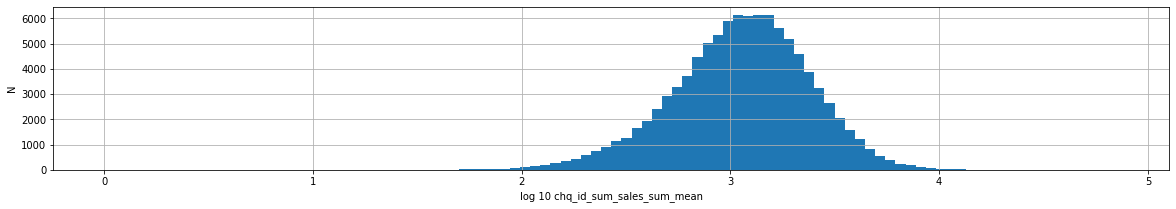

In [44]:
#Средний чек на клиента, усредненные по клиентам

df_client['chq_id_sum_sales_sum_mean'].apply(lambda x: np.log10(1+x)).hist(figsize = (20, 3), bins = 100)
# plt.xticks(np.linspace(0, 15, 15), [10**i for i in np.linspace(0, 3, 10)])

plt.xlabel("log 10 chq_id_sum_sales_sum_mean")
plt.ylabel("N")
plt.show()



In [45]:
# res['chq_id_sum_count_sum_mean']

In [46]:
# df.loc[df['client_id']=='1a47d62dddacc03fe90c15652f7ae1a4'].drop_duplicates("chq_id")['chq_id_sum_sales_sum'].mean()#.unqiue()

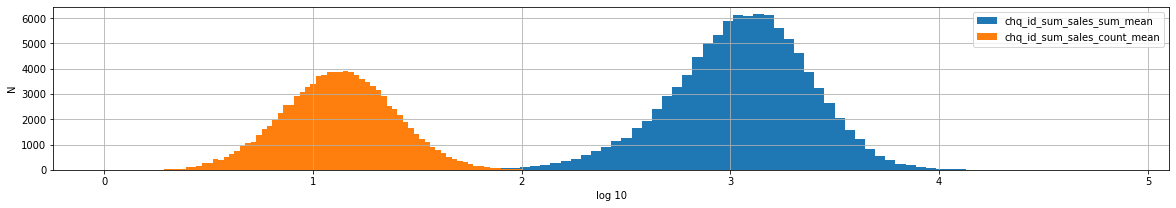

In [916]:
df_client['chq_id_sum_sales_sum_mean'].apply(lambda x: np.log10(1+x)).hist(figsize = (20, 3), 
                                                                            bins = 100, 
                                                                            label = 'chq_id_sum_sales_sum_mean')
plt.xlabel("log 10")
plt.ylabel("N")



#Среднее количество товаров в чеке на клиента, усредненные по клиентам
df_client['chq_id_sum_sales_count_mean'].apply(lambda x: np.log10(1+x)).hist(figsize = (20, 3), 
                                                                             bins = 100,
                                                                             label = 'chq_id_sum_sales_count_mean')


plt.legend()
plt.show()


In [49]:
t_data_start = df_client['t_min'].max()
t_data_start

Timestamp('2017-01-03 00:00:00')

> В выбороке есть только клиенты которые присоедениелись к программе лояльности 2017-01-03
  За 9 месяцев до финальной даты

In [50]:
df_client_raw = pd.read_csv('clients.csv')
print('df_client_raw.shape', df_client_raw.shape)
df_client_raw.head()

df_client_raw.shape (99995, 4)


,client_id,gender,city,birthyear
0,1a47d62dddacc03fe90c15652f7ae1a4,M,Other,1990.0
1,9cb909f701d25d548e953bff81192b56,F,Other,1969.0
2,d5da0f5b841b4f83383202807995027a,M,Other,1976.0
3,13ed7f16810b17b8cee6de834ac79a48,F,Moscow,1966.0
4,215fe3ea7d5bf0415e5504e2a7f33551,F,Other,1988.0


In [51]:
# Сколько уникальных элементов, что за тип
for key in df_client_raw.keys():
    print(f"{key} {' '*(20-len(key))}  {df_client_raw[key].nunique()} \t {df_client_raw[key].dtype} \t {df_client_raw[key].isna().sum()}")

client_id              99995 	 object 	 0
gender                 2 	 object 	 355
city                   3 	 object 	 0
birthyear              107 	 float64 	 1776


In [54]:
df_client['client_id'] = df_client.index.tolist()

#### Странно, но куда-то пропали 5 пользователей

In [55]:
df_client[~df_client['client_id'].isin(df_client_raw['client_id'].unique())]

,t_min,t_max,_t_list,items_N,items_sales_sum_sum,items_sales_count_sum,items_N_negative,items_sales_sum_sum_negative,items_sales_count_sum_negative,item_price_mean,...,"delta_bin_224_(448,)",plant_key_0,plant_val_0,material_key_0,material_val_0,plant_key_1,plant_val_1,material_key_1,material_val_1,client_id
client_id,,,,,,,,,,,,,,,,,,,,,
3ff5567abe9de12b87180220deec0311,2016-10-11,2017-09-01,"[2016-10-11T00:00:00.000000000, 2016-10-12T00:...",20,20427.0,239.732,0,0.0,0.0,16.725905,...,0.0,5968996e0aca329cf3218086223f8308,0.60,4417aec68c5c2537f22c8c36d696d6b3,0.028571,29150bb2319c182c944841c74d2f8d75,0.350,b75147feae4cf8ec07fb5f2cef855def,0.028571,3ff5567abe9de12b87180220deec0311
6d6857d997aea7ddee6107734bf1acfd,2016-10-04,2017-09-22,"[2016-10-04T00:00:00.000000000, 2016-10-26T00:...",25,83003.0,997.465,0,0.0,0.0,61.309044,...,0.0,3d842a955f86c5982f18ed6fea9fa1a9,0.64,6278f48a43fb0a23036b3a11c92e726c,0.016327,c3b86052d1fc94bd11c279a17f3f25e1,0.240,3bafe05aabf85a888d85a966fb853ebf,0.014966,6d6857d997aea7ddee6107734bf1acfd
94bf299e419de3e1d359e67d8868dc43,2016-11-23,2017-03-21,"[2016-11-23T00:00:00.000000000, 2016-11-28T00:...",10,10861.0,144.130,0,0.0,0.0,16.244503,...,0.0,a9b2b0ce7799c4de9c7a3aed9ebeddeb,0.80,23f552a9126cedd94df4a760107773de,0.040816,c0f82517af0829daac3a6cf82e9ecc1e,0.100,f6f249bb66b7b9e1737d923b34681d53,0.034014,94bf299e419de3e1d359e67d8868dc43
d6e77dc47ead0049e5be7f6f4330cee2,2016-10-14,2017-08-23,"[2016-10-14T00:00:00.000000000, 2016-10-31T00:...",10,18716.0,160.482,0,0.0,0.0,20.566309,...,0.0,a4e23b2609285cfd99de6d9832f21df1,1.00,808c99c5030afc5da6586192eef04453,0.026846,NaN,NaN,e12f143279e2ac09f63f29bebe99ce9f,0.020134,d6e77dc47ead0049e5be7f6f4330cee2
f284fc3143decf0ef4f93d7e75e5d6d0,2016-10-15,2017-09-26,"[2016-10-15T00:00:00.000000000, 2016-10-16T00:...",40,40030.0,486.471,0,0.0,0.0,18.958291,...,0.0,857778a20b9a41d4ca0d687a36e4bfa8,0.85,dd040b62c01930efe45d65c4e5ac754b,0.026667,540bd55a2cf295b8ea9cd78650e89d03,0.125,142d63107737a448dc2dfe2dcd0154b8,0.024000,f284fc3143decf0ef4f93d7e75e5d6d0


#### Обьединим таблицы

In [56]:
df_client = df_client.join(df_client_raw.set_index("client_id"))

In [57]:
df_client[df_client2['city'].isna()]

#проверка что наны там где 5 клиентов

NameError: name 'df_client2' is not defined

In [58]:
#рисует пользовательскую траекторию для n клиентов

def _print_user_times(N = 20, fn_out = None):
    user_sample = df_client['client_id'].sample(N, random_state = 42).to_numpy()

    o = df_client.loc[df_client['client_id'].isin(user_sample)]#, "_t_list"]
    y_ticks = []
    plt.figure(figsize = (20, 10))
    plt.title('User datetimes', fontsize = 22)
    plt.xlabel('time',    fontsize = 16)
    plt.ylabel('user_id', fontsize = 16)
    
    for c, (cliend_id, data) in enumerate(o.sort_values('t_max').iterrows()):
        x_list = data['_t_list']#.to_numpy()
        y_list = [c+1] * len(x_list)


        plt.scatter(x_list, 
                    y_list, 
                    s = 10,
                    marker = 'o')

        y_ticks.append(data['client_id'])

    plt.yticks(list(range(1, 1+len(y_ticks))), y_ticks)
    plt.plot([t_data_start, t_data_start], 
             [0, N+1], 
             label = f't_start = {t_data_start}',
             color = 'red', 
             linestyle = '--', 
             linewidth = 5,
             alpha = 0.2)

    plt.ylim(0, N+1)
    
    plt.legend(loc = "lower right", fontsize = 18)
    plt.grid()
    
    if fn_out is not None:
        plt.savefig(fn_out)
    
    plt.show()

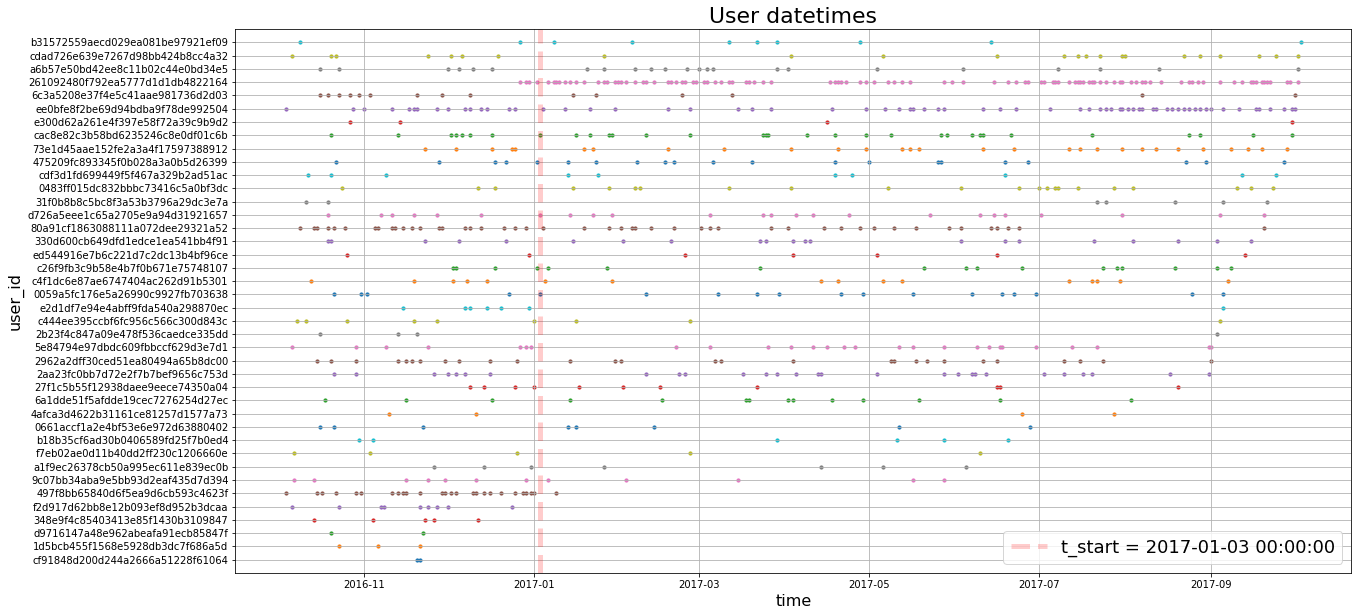

In [59]:
_print_user_times(40, fn_out = "results/users_datetime_40")

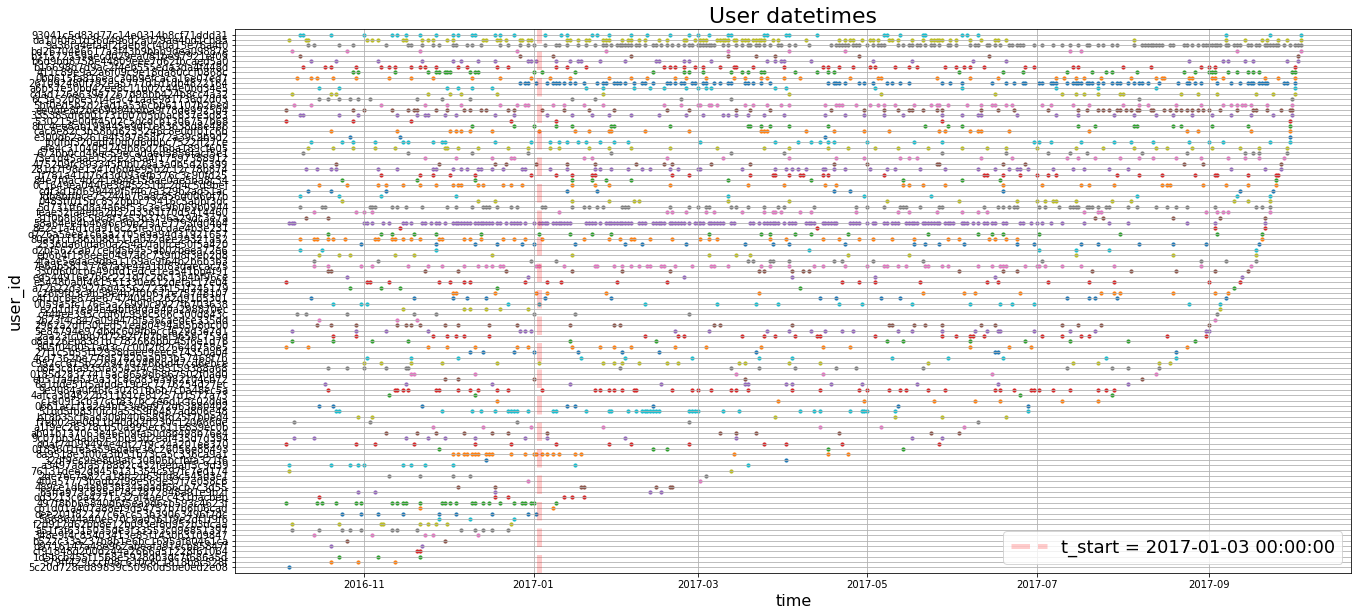

In [60]:
_print_user_times(100, fn_out = "results/users_datetime_100")

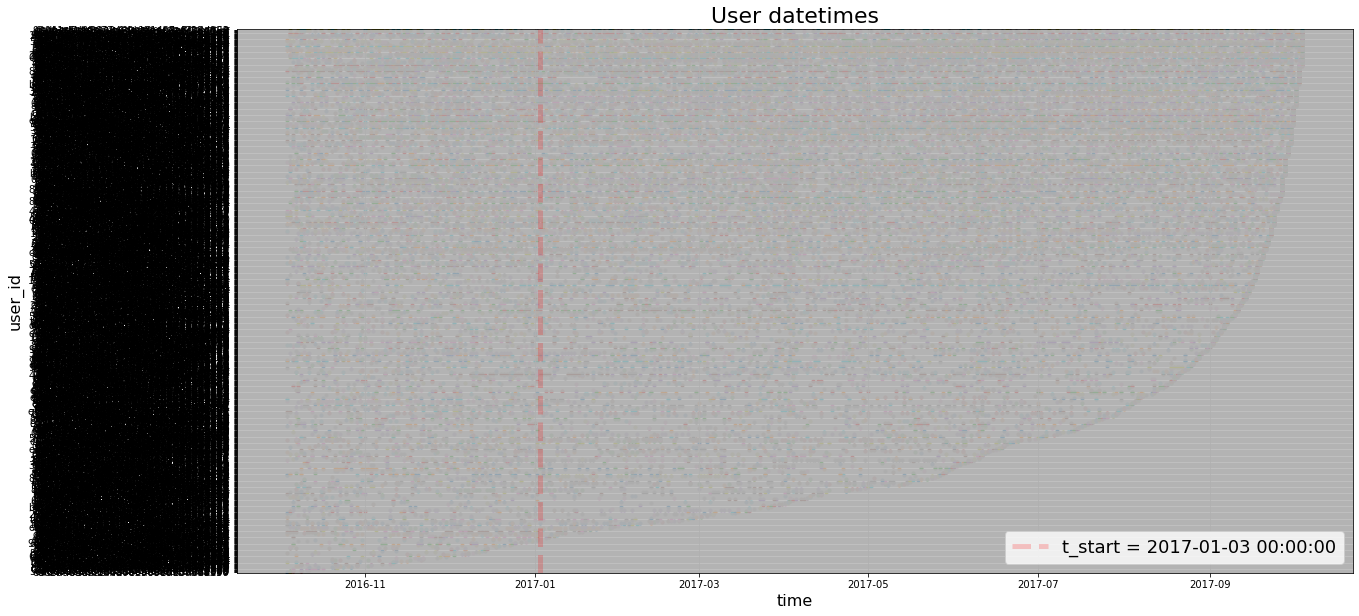

In [61]:
_print_user_times(1000, fn_out = "results/users_datetime_1000")

###  Как часто в среднем хотяж в Ленту?


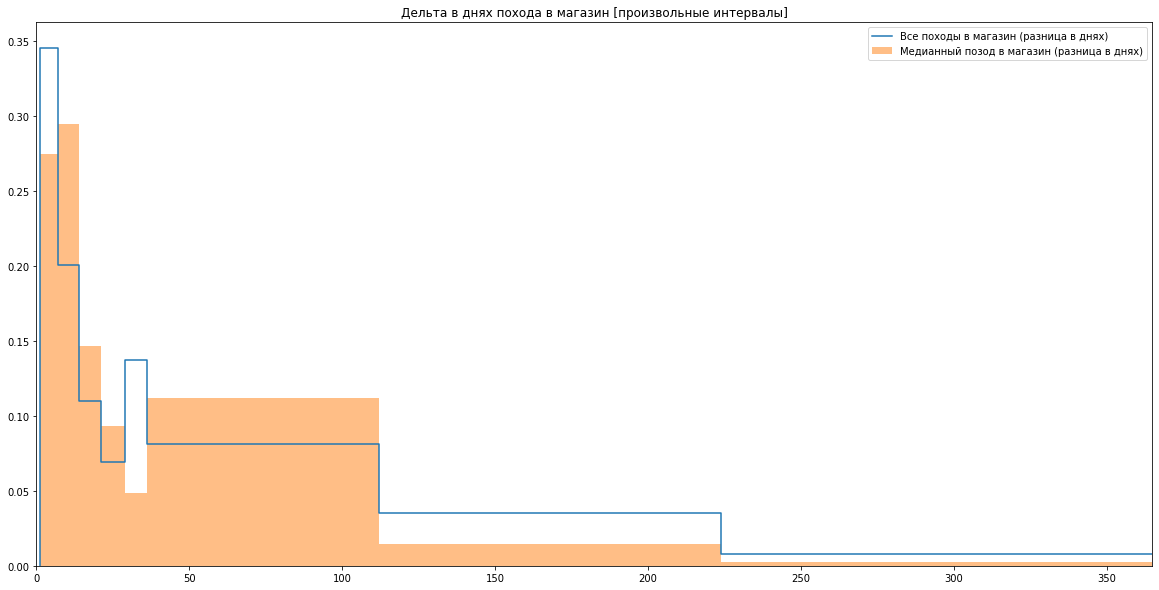

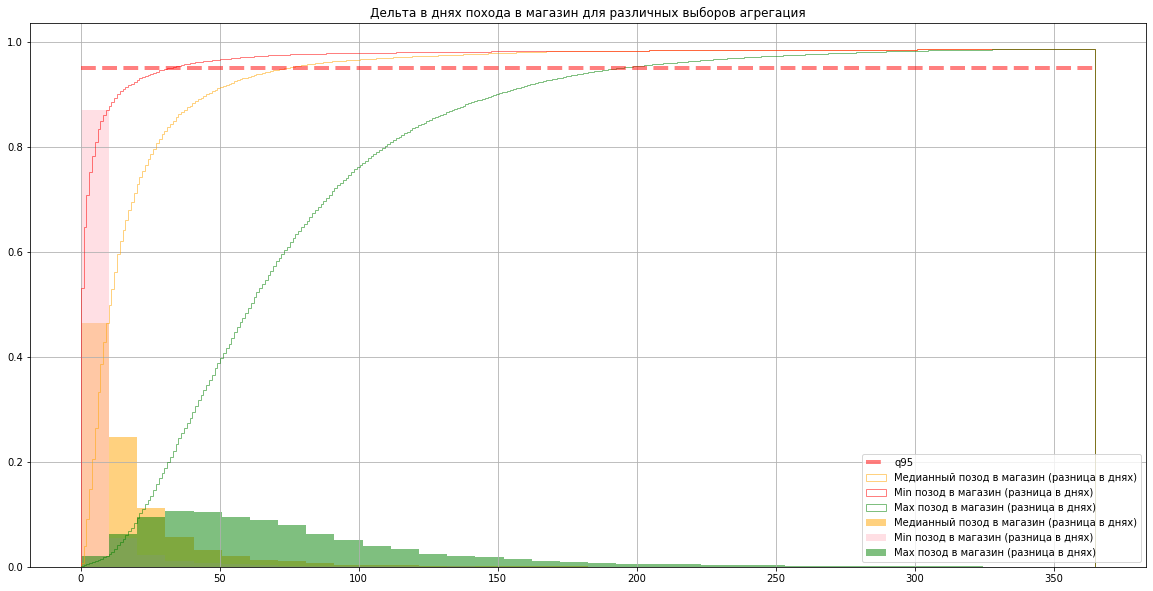

In [62]:
N = len(df_client)#.keys()
o = (df_client[['delta_bin_0_(1,)', 'delta_bin_1_(7,)', 'delta_bin_7_(14,)',
                'delta_bin_14_(21,)', 'delta_bin_21_(28,)', 'delta_bin_28_(56,)',
                'delta_bin_56_(112,)', 'delta_bin_112_(224,)', 'delta_bin_224_(448,)']].sum(axis = 0)/N)

x_list = [1,7,14,21,29,36,112,224, 448]
# print(len(o), len(x_list))
plt.figure(figsize = (20, 10))
plt.title('Дельта в днях похода в магазин [произвольные интервалы]')

plt.step(x_list, o.to_numpy(), label = 'Все походы в магазин (разница в днях)')
plt.hist(df_client['delta_median'],
         weights = np.ones(len(df_client))/len(df_client), 
         alpha = 0.5, bins = [0]+x_list,
         label = 'Медианный позод в магазин (разница в днях)')

plt.legend()
plt.xlim(0, 365)
plt.show()

plt.figure(figsize = (20, 10))

plt.title('Дельта в днях похода в магазин для различных выборов агрегация')
bins = np.linspace(0, 365, 365)


plt.hist(df_client['delta_median'],
         weights = np.ones(len(df_client))/len(df_client), 
         alpha = 0.5, 
         color = 'orange',histtype='step',
         bins = bins, cumulative=1,
         label = 'Медианный позод в магазин (разница в днях)')

plt.hist(df_client['delta_min'],
         weights = np.ones(len(df_client))/len(df_client), 
         alpha = 0.5, 
         color = 'red',histtype='step',
         bins = bins, cumulative=1,
         label = 'Min позод в магазин (разница в днях)')

plt.hist(df_client['delta_max'],
         weights = np.ones(len(df_client))/len(df_client), 
         alpha = 0.5, 
         color = 'green',histtype='step',
         bins = bins, cumulative=1,
         label = 'Max позод в магазин (разница в днях)')

bins = np.linspace(0, 365, 37)

plt.hist(df_client['delta_median'],
         weights = np.ones(len(df_client))/len(df_client), 
         alpha = 0.5, 
         color = 'orange',
         bins = bins, 
         label = 'Медианный позод в магазин (разница в днях)')

plt.hist(df_client['delta_min'],
         weights = np.ones(len(df_client))/len(df_client), 
         alpha = 0.5, 
         color = 'pink',
         bins = bins, 
         label = 'Min позод в магазин (разница в днях)')

plt.hist(df_client['delta_max'],
         weights = np.ones(len(df_client))/len(df_client), 
         alpha = 0.5, 
         color = 'green',
         bins = bins, 
         label = 'Max позод в магазин (разница в днях)')

plt.plot([0, 365], [0.95, 0.95],
         label = 'q95',
         linewidth = 4,
         linestyle = '--', 
         color = 'red', alpha = 0.5)
plt.grid()
plt.legend()
plt.show()

##### Из этого можно сделать вывод, что оптимальным значение t2-t1 должен лежать в диапазоне от 60 до 200 дней
##### Чтобы ошибка нашеq разметки была порядка 5%


Для простоты положим t1-t2 = 60 дней (два месяца)

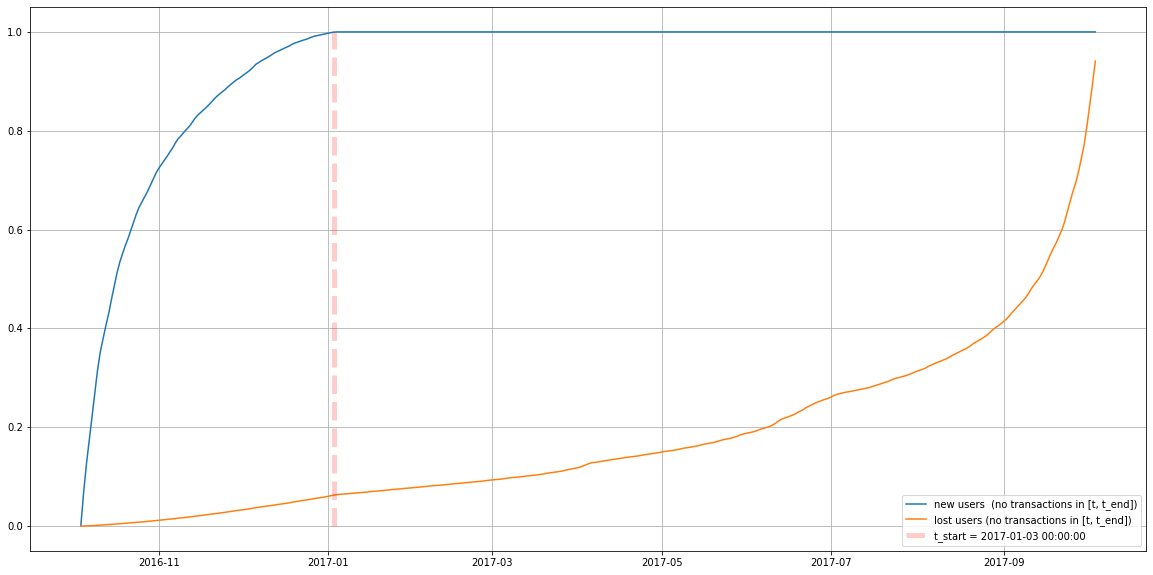

In [63]:
new_users   = []
lost_users = []
t_list = []
for t in list(sorted(df['chq_date'].drop_duplicates())):
    new_users.append((df_client['t_min']<t).mean())
    lost_users.append((df_client['t_max']<t).mean())
    t_list.append(t)
    
plt.figure(figsize = (20, 10))
plt.plot(pd.to_datetime(t_list), 
         new_users,  label = 'new users  (no transactions in [t, t_end])')

plt.plot(pd.to_datetime(t_list), 
         lost_users, label = 'lost users (no transactions in [t, t_end])')

plt.plot([t_data_start, t_data_start], 
         [0, 1], 
         label = f't_start = {t_data_start}',
         color = 'red', 
         linestyle = '--', 
         linewidth = 5,
         alpha = 0.2)


plt.legend()
plt.grid()
plt.show()

In [65]:
# new_users
#по накклону начальной части оранжевой кривой можно судить об уходеasdf
5
366**2*11/60
# /60/24

24558.6

In [66]:
N

100000

#### Необходимо выбрать корректные отсечки для t1, t2

> Построим несколько графиков, может быть что-то станет яснее

In [67]:
df_client['_t_list2'] = df_client['_t_list'].apply(lambda x:np.array(x))
#.loc['0000d48a8891cd462fdf01ea861ec53e']

In [68]:
# c1 = np.array([True, False])
# c2 = np.array([True, False])
# (c1 & c2).any()
t1

NameError: name 't1' is not defined

In [70]:
%%time
# np.sum([((i<t1)  | (i>t1)).any() and (max(i)>t2) for i in df_client['_t_list2'].to_numpy()])
np.sum([((i<t1)  | (i>t2)).all() & 
        (i.max()>t2) for i in fast_error_numpy])

NameError: name 'fast_error_numpy' is not defined

In [71]:
%%time
# Запускается долго
# [FILL TEXT], добавить картинку с ошибками

N_users     = {}
Churn_users = {}
# N_error     = {}

for t1 in tqdm.tqdm(list(sorted(df['chq_date'].unique())), 
                    total = df['chq_date'].nunique()):
    #print(t1)
    N_users[t1] = {}
    Churn_users[t1] = {}
    #N_error[t1] = {}
    
    for t2 in list(sorted(df['chq_date'].unique())):
        if t1>t2:
            continue
        
        #users_in_data = df_client[df_client['t_min']>t1, 'client_id']
        
        N_users[t1][t2]     = (df_client['t_max']>t1).sum()
        Churn_users[t1][t2] = (df_client[df_client['t_max']>t1]['t_max']<t2).sum()
        
print('Finish')

100%|██████████| 366/366 [35:22<00:00,  5.80s/it] 

Finish
CPU times: user 35min 19s, sys: 4.81 s, total: 35min 24s
Wall time: 35min 23s


In [72]:
# len(N_error)

In [74]:
%%time
# Запускается долго
# [FILL TEXT], добавить картинку с ошибками

# N_users     = {}
# Churn_users = {}
N_error     = {}

fast_error_numpy = df_client['_t_list2'].to_numpy()
 

for t1 in tqdm.tqdm(list(sorted(df['chq_date'].unique()))[::30], total = df['chq_date'].nunique()/30):
    #print(t1)
    #N_users[t1] = {}
    #Churn_users[t1] = {}
    N_error[t1] = {}
    
    for t2 in list(sorted(df['chq_date'].unique()[::30])):
        if t1>t2:
            continue
        
        #users_in_data = df_client[df_client['t_min']>t1, 'client_id']
        
        #N_users[t1][t2]     = (df_client['t_max']>t1).sum()
        #Churn_users[t1][t2] = (df_client[df_client['t_max']>t1]['t_max']<t2).sum()
        
        #temp = df_client['_t_list']
        N_error[t1][t2] = np.sum([((i<t1)  | (i>t2)).all() and (np.max(i)>t2) for i in fast_error_numpy])
        #      ((df_client['t_max']>t1) & (df_client['_t_list'].apply(lambda lst: any([(t1<x) and (x<t2) 
        #                                                                                                   for x in lst])
        #                                                                                 ))).sum()
print('Finish')

  0%|          | 0/52.285714285714285 [00:12<?, ?it/s]


KeyboardInterrupt: 

In [78]:
# list(N_users.keys())[10]
0

0

In [ ]:
# N_users[np.datetime64('2016-10-14T00:00:00.000000000')]

#### Посмотрим на пользователей в выборке

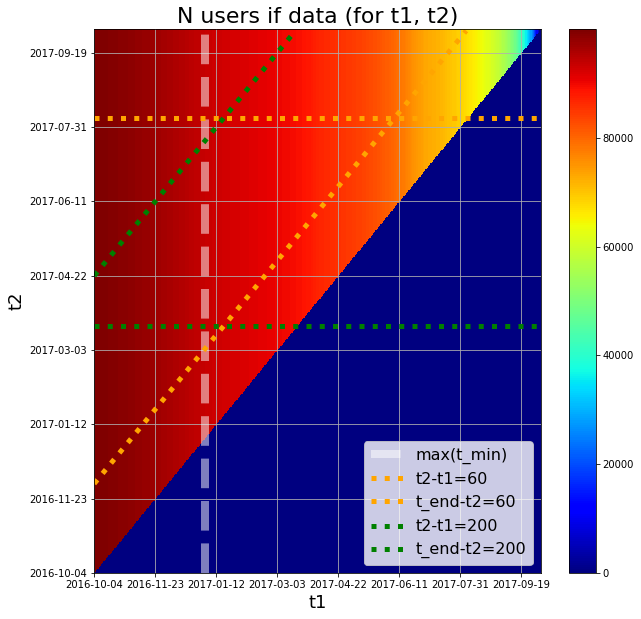

In [75]:
plt.figure(figsize = (10,10))
plt.title("N users if data (for t1, t2)", fontsize = 22)
plt.xlabel("t1", fontsize = 18)
plt.ylabel("t2", fontsize = 18)

t_list = list(sorted(df['chq_date'].drop_duplicates()))
M      = np.zeros((len(t_list), len(t_list)))
for c1, (k1, o1) in enumerate(N_users.items()):
    i1 = t_list.index(k1)
    for c2, (k2, v) in enumerate(o1.items()):
        i2 = t_list.index(k2)        
        M[i2, i1] = v
plt.pcolormesh(M, cmap=plt.cm.jet)
plt.xlabel
plt.colorbar()
plt.grid()
plt.xticks( range(len(t_list))[::50], [str(i)[:10] for i in t_list[::50]], fontsize = 10)
plt.yticks( range(len(t_list))[::50], [str(i)[:10] for i in t_list[::50]], fontsize = 10)

t_index_start = t_list.index(t_data_start)
plt.plot([t_index_start, t_index_start],
         [0, len(t_list)],
         '--', 
         label = 'max(t_min)', 
         linewidth = 8,
         alpha = 0.5,
         color = 'white')

for  clr, deltat1t2 in [['orange', 60], 
                        ['green', 200]]:
    t1_list = list(range(0, len(t_list)-deltat1t2))
    t2_list = [t+deltat1t2 for t in t1_list]
    plt.plot(t1_list, t2_list, 
             label = f't2-t1={deltat1t2}', 
             linestyle = ':', 
             linewidth = 5,
             #alpha = 0.6, 
             color = clr)
    
    plt.plot([0, len(t_list)],
            [len(t_list)-deltat1t2, len(t_list)-deltat1t2],
             label = f't_end-t2={deltat1t2}', 
             linestyle = ':', 
             linewidth = 5,
             #alpha = 0.6, 
             color = clr)
    


    
plt.legend(fontsize = (16), loc = 'lower right')
plt.show()

> Видно, что количество пользователей в выборке для обучения зависит только от t1

In [76]:
all([len(set(i.values()))==1 for i in N_users.values()])

True

In [77]:
list(list(N_users.items())[0][1].items())[0],\
list(list(N_users.items())[2][1].items())[0]

((numpy.datetime64('2016-10-04T00:00:00.000000000'), 99982),
 (numpy.datetime64('2016-10-06T00:00:00.000000000'), 99944))

> Скорее всего В интервале от 0 до max(t_min) Падает количество N_users в основном за счет пользователей только с одной покупкой
(купили карту и сразу ее потеряли)

In [ ]:
#Можно заметить, что есть пользователи только с одной транзакцией
df_client.loc['8f86d689f835936fb38187f1309719c5'].head()

#### Посмотрим на churn users

In [ ]:
plt.figure(figsize = (10,10))
plt.title("N churn users (for t1, t2)", fontsize = 22)
plt.xlabel("t1", fontsize = 18)
plt.ylabel("t2", fontsize = 18)

t_list = list(sorted(df['chq_date'].drop_duplicates()))
M      = np.zeros((len(t_list), len(t_list)))
for c1, (k1, o1) in enumerate(Churn_users.items()):
    i1 = t_list.index(k1)
    for c2, (k2, v) in enumerate(o1.items()):
        i2 = t_list.index(k2)        
        M[i2, i1] = v
plt.pcolormesh(M, cmap=plt.cm.jet)# cmap=cmap, rasterized=True, vmin=-4, vmax=4)
plt.xlabel
plt.colorbar()
plt.grid()
plt.xticks( range(len(t_list))[::50], [str(i)[:10] for i in t_list[::50]], fontsize = 10)
plt.yticks( range(len(t_list))[::50], [str(i)[:10] for i in t_list[::50]], fontsize = 10)

t_index_start = t_list.index(t_data_start)
plt.plot([t_index_start, t_index_start],
         [0, len(t_list)],
         '--', 
         label = 'max(t_min)', 
         linewidth = 8,
         alpha = 0.5,
         color = 'white')

for  clr, deltat1t2 in [['orange', 60], 
                        ['green', 200]]:
    t1_list = list(range(0, len(t_list)-deltat1t2))
    t2_list = [t+deltat1t2 for t in t1_list]
    plt.plot(t1_list, t2_list, 
             label = f't2-t1={deltat1t2}', 
             linestyle = ':', 
             linewidth = 5,
             #alpha = 0.6, 
             color = clr)
    
    plt.plot([0, len(t_list)],
            [len(t_list)-deltat1t2, len(t_list)-deltat1t2],
             label = f't_end-t2={deltat1t2}', 
             linestyle = ':', 
             linewidth = 5,
             #alpha = 0.6, 
             color = clr)
    


plt.legend(fontsize = (16), loc = 'lower right')
plt.show()

> В абсолютной величине количество пользователей которые считаются churn зввисит и от t1 и от t2

In [ ]:
# dct

In [ ]:
plt.figure(figsize = (10,10))
plt.title("Churn rate (for t1, t2)", fontsize = 22)
plt.xlabel("t1", fontsize = 18)
plt.ylabel("t2", fontsize = 18)

t_list = list(sorted(df['chq_date'].drop_duplicates()))
M      = np.zeros((len(t_list), len(t_list)))
dct = {k1:{k2:v2/N_users[k1][k2] for k2, v2 in o.items()} 
       for k1,o in Churn_users.items()}

for c1, (k1, o1) in enumerate(dct.items()):
    i1 = t_list.index(k1)
    for c2, (k2, v) in enumerate(o1.items()):
        i2 = t_list.index(k2)        
        M[i2, i1] = v
        
plt.pcolormesh(M, cmap=plt.cm.jet)#, rasterized=True, vmin=-4, vmax=4)
plt.xlabel
plt.colorbar()
plt.grid()
plt.xticks( range(len(t_list))[::50], [str(i)[:10] for i in t_list[::50]], fontsize = 10)
plt.yticks( range(len(t_list))[::50], [str(i)[:10] for i in t_list[::50]], fontsize = 10)

t_index_start = t_list.index(t_data_start)
plt.plot([t_index_start, t_index_start],
         [0, len(t_list)],
         '--', 
         label = 'max(t_min)', 
         linewidth = 8,
         alpha = 0.5,
         color = 'white')

# Нарисуем график t2-t1 = 60, t2=t1+60
for  clr, deltat1t2 in [['orange', 60], 
                        ['green', 200]]:
    t1_list = list(range(0, len(t_list)-deltat1t2))
    t2_list = [t+deltat1t2 for t in t1_list]
    plt.plot(t1_list, t2_list, 
             label = f't2-t1={deltat1t2}', 
             linestyle = ':', 
             linewidth = 5,
             #alpha = 0.6, 
             color = clr)
    
    plt.plot([0, len(t_list)],
            [len(t_list)-deltat1t2, len(t_list)-deltat1t2],
             label = f't_end-t2={deltat1t2}', 
             linestyle = ':', 
             linewidth = 5,
             #alpha = 0.6, 
             color = clr)
    

plt.legend(fontsize = (16), loc = 'lower right')
plt.show()

In [ ]:
df['chq_date'].max()

Подъитожим:

        - Выбирая t1-t2 большим(например 150 дней, 200 дней не везают), мы получаем
        - Cильный дисбаланс классов и маленький размер выборки с churn
          
          На самом деле в задаче определения churn нас не столько интересуют уйдет пользователь или нет, 
          как ранжирующая способность определяющая вероятность - уйдет пользоватлеь или нет.
          Так как скорее всего результаты системы определения churn могут быть использованы:
            Для оптимизации call центра, уведомлений и других спослобов взаимодействия с клиентов
          Но от дисбаланса классоа едет и качество модели и дисперсии многих метрик.
          Поэтому дисбаланс классов, это действительно важная проблема
            
        - В нашей разметке мы умешаяем количество FN (разметка что не churn, а подьзователь начал churn)
            
    - Выбирая t2 близко к t1
        - Модель учится на более свежих данных
        
        - Мы увеличиваем долю класса churn
        
        - В разметке уменьшаяем ошибки типо FP (разметка что churn, а на самом деле не churn) 

Можно конечно выбирать отсечки автоматичски для каждого клиента, но это сильное усложнение задачи.
Из картинки 4 выше, если в среднем пользователь ходит в магазин раз в неделю, раз в год бывает что он не ходит в магазин два месяца.

Взвешивая все за и против:
    
    - Нормальный баланс churn
    - чуть большую ошибку в целом (но все-де менее 5%) (больше ошибку разметки FP, )
    - уменьшаем ошибки FN
    - Из всего сказанного выше
    - Мы скорее всего получим чуть большую ранжирующую способность алгоритма
    - Два месяца это нормальный срок для предсказания (в банке просрочка по кредитам считается 30-90 дней)
    
    t_end = "2017-10-04"
    t2    = "2017-08-04"
    t1    = "2017-06-04"

In [ ]:
### Создание модели и валидация

Окно для признаков стоит зафиксировать (потому-что если данные будут копится некоторые признаки поедут)
Либо все признаки должны не закисить от количества данных (нет функций сумм, есть функции mean)
Принципиально сздесь можно использовать два типа моделей

In [ ]:
t2 = pd.to_datetime("2017-08-04")
t1 = pd.to_datetime("2017-06-04")

df_client['y_2017-10-04'] = None
df_client.loc[df_client['t_max']>t1,  'y_2017-10-04'] = 1
df_client.loc[df_client['t_max']>t2,  'y_2017-10-04'] = 0

good_clients = df_client.loc[df_client['y_2017-10-04'].notna(), 'client_id']


df_client['y_2017-10-04'].astype(str).value_counts()

In [ ]:
def get_features(dtype):
    if dtype == 'small':
        df_all = df.loc[(df['chq_date']>t1) & 
                        (df['chq_date']<t2)].groupby('client_id').apply(_get_features)
        df_all['client_id'] = df_all.index.to_numpy()
        
    if dtype == 'all':
        df_all   = df.loc[(df['client_id'].isin(good_clients)) & 
                          (df['chq_date']<t2)].groupby('client_id').apply(_get_features)
    df_all['client_id'] = df_all.index.to_numpy()

    df_client_raw = pd.read_csv('clients.csv')
    print('df_client_raw.shape', df_client_raw.shape)
    df_all = df_all.join(df_client_raw.set_index("client_id"))
    
    return df_all

In [ ]:
# 70872-67661
len(good_clients)

In [ ]:
df.loc[(df['chq_date']>t1) & (df['chq_date']<t2), 
       'client_id'].nunique()

In [ ]:
10000/70872

Признаки(маленькие только за 2 месяца)

In [ ]:


# clieant_features_small = df.loc[(df['chq_date']>t1) & 
#                                 (df['chq_date']<t2)].groupby('client_id').apply(_get_features)


# df_client_raw = pd.read_csv('clients.csv')
# print('df_client_raw.shape', df_client_raw.shape)
# df_client_raw.head()

# # clieant_features_small =
# clieant_features_small['client_id'] = clieant_features_small.index.to_numpy()

In [ ]:
df_all = get_features('small')

In [ ]:
print('error rate %3.3f%%'%(100*(len(good_clients)-df_all['client_id'].nunique())/len(good_clients)))

In [ ]:
# df_all = clieant_features_small.join(df_client_raw.set_index("client_id"))#['client_id'].nunqiue()
# df_all

In [ ]:
# clieant_features_small

In [ ]:
# o['client_id'].nunique()

In [ ]:
df.keys()

In [ ]:
df['chq_id']

In [ ]:
def diff_to_days(x):
    return x / np.timedelta64(1, 's') / 60 / 60 / 24

deltas = diff_to_days(np.diff(t))
print("deltas", deltas)
np.median(deltas)
np.min(deltas)
np.max(deltas)
np.argmax(np.bincount(deltas.astype(int)))

bins = [0, 1, 7, 14, 21, 28, 56, 112, 224, 448]
for l in range(1, len(bins)):
    print(bins[l-1], bins[l], np.mean([((bins[l-1]<=x) and (x<bins[l]))  for x in deltas]))
[]

In [ ]:
# counts = np.bincount(deltas.astype(int))
print(np.argmax(np.bincount(deltas.astype(int))))

In [ ]:
np.bincount(deltas)

In [ ]:
np.diff(t)

In [ ]:
t.s

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, classification_report
y = [0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,0,1,3,4,5,6]
p = [0,1,0,0,0,0,1,0,0,0,1,0,0,1,1,1,1,1,0,0,0,0]

# confusion_matrix(y, p )
print(classification_report(y, p))

### Создадим модель

In [213]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split

In [ ]:
%%time

def diff_to_days(x):
    return x / np.timedelta64(1, 's') / 60 / 60 / 24

def _get_features(data):
    data_no_duplicates = data.drop_duplicates("chq_id")
    data_negative      = data[data['sales_sum']<0]
    
    t_list = list(sorted(data_no_duplicates['chq_date'].unique()))
    deltas = diff_to_days(np.diff(t_list)) #интервалы между датами транзакций
    bins = [0, 1, 7, 14, 21, 28, 56, 112, 224, 448]
    res = {
           't_min'  : data['chq_date'].min(),          # Даты (первая, последняя и весь список)
           't_max'  : data['chq_date'].max(),  
           '_t_list' : t_list,
        
           'items_N' : data['chq_id'].nunique(),              # Количество пробитых товаров
           'items_sales_sum_sum':data['sales_sum'].sum(),     # Сколько потратил
           'items_sales_count_sum':data['sales_count'].sum(), # Сколько покупок сделал

           'items_N_negative' : data_negative['chq_id'].nunique(),              # Количество пробитых товаров
           'items_sales_sum_sum_negative':data_negative['sales_sum'].sum(),     # Сколько потратил
           'items_sales_count_sum_negative':data_negative['sales_count'].sum(), # Сколько покупок сделал
           
           "item_price_mean" : data['chq_id_sum_sales_count'].mean(), # Средняя цена товара
           "item_price_max"  : data['chq_id_len'].max(),              # Максимальная цена товара
           "item_price_min"  : data['chq_id_sum_sales_sum'].min(),    # Минимальная цена товара
           
        
           'chq_id_sum_sales_count_mean':data_no_duplicates['chq_id_sum_sales_count'].mean(),   # Средний количество покупок
           'chq_id_len_mean':data_no_duplicates['chq_id_len'].mean(),                           # Средее количнтво товаров
           'chq_id_sum_sales_sum_mean':data_no_duplicates['chq_id_sum_sales_sum'].mean(),       # Средняя цена товаров
                   
           'chq_id_sum_sales_count_min':data_no_duplicates['chq_id_sum_sales_count'].min(),  # То-же самое для минимума
           'chq_id_len_min':data_no_duplicates['chq_id_len'].min(),
           'chq_id_sum_sales_sum_min':data_no_duplicates['chq_id_sum_sales_sum'].min(),
            
           
           'chq_id_sum_sales_count_max':data_no_duplicates['chq_id_sum_sales_count'].max(), # То-же самое для максимума
           'chq_id_len_max':data_no_duplicates['chq_id_len'].max(),
           'chq_id_sum_sales_sum_max':data_no_duplicates['chq_id_sum_sales_sum'].max(),
        
           'promo_rate_count': (data['is_promo']==1).mean(),    # Доля промо
           'promo_rate_sales_sum': (data.loc[(data['is_promo']==1), 'sales_sum'].sum()+1)/(data['sales_sum'].sum()+1),
           'promo_rate_sales_count': (data.loc[(data['is_promo']==1), 'sales_count'].sum()+1)/(data['sales_count'].sum()+1),
        
            "delta_median" : np.median(deltas) if len(deltas)>0 else np.nan, # 
            "delta_min"    : np.min(deltas) if len(deltas)>0 else np.nan,
            "delta_max"    : np.max(deltas) if len(deltas)>0 else np.nan,
            "delta_std"    : np.std(deltas) if len(deltas)>0 else np.nan,
            "delta_moda"   : np.argmax(np.bincount(deltas.astype(int))) if len(deltas)>0 else np.nan,
          }
    
    # Позитивные транзакции
    res['items_N_positive']               = res['items_N']-res['items_N_negative']
    res['items_sales_sum_sum_positive']   = res['items_sales_sum_sum']-res['items_sales_sum_sum_negative']
    res['items_sales_count_sum_positive'] = res['items_sales_count_sum']-res['items_sales_count_sum_negative']
    
    
    # Отношение негативного к позитивному
    ##res['negative_pos_rate_len_positive'] = res['negative_pos_rate_len']  -res['negative_pos_rate_len_negative']  
    for l in range(1, len(bins)):
        res[f'delta_bin_{bins[l-1]}_{bins[l],}'] = np.mean([((bins[l-1]<=x) and (x<bins[l]))  for x in deltas])
    
    
    for c in range(2):
        res[f'plant_key_{c}'] = np.nan
        res[f'plant_val_{c}'] = np.nan 
        res[f'material_key_{c}'] = np.nan
        res[f'material_val_{c}'] = np.nan 
        
    # Самые популярные города по количеству и из доля
    for c, (key, val) in enumerate(data_no_duplicates['plant'].value_counts(True).to_dict().items()):
        if c>=2:
            break

        res[f'plant_key_{c}'] = key
        res[f'plant_val_{c}'] = val     
    #два топовых магазина для юзера
        
    # Самые популярные товары по количеству и из доля    
    for c, (key, val) in enumerate(data['material'].value_counts(True).to_dict().items()):
        if c>=2:
            break
            
        res[f'material_key_{c}'] = key
        res[f'material_val_{c}'] = val  
    
    # Добавить join на metrials из таблицы 'materials.txt'
    # Добавить join на plant из таблицы пользователей если для каждого магазина взять максимальное количество пользователей с городом, это должно помоч
    
    return pd.Series(res)  

# _get_features(df[:100])
# user_sample = ["1a47d62dddacc03fe90c15652f7ae1a4"]#df['client_id'].sample(5000, random_state = 42).to_numpy()
# res = df[df['client_id'].isin(user_sample)].groupby('client_id').apply(_get_features)
# res
df_client = df.groupby('client_id').apply(_get_features)
# df_client['client_id'] = df_client.index
# print('Finish calculating')

df_client.to_parquet("results/df_client_id.parquet")
# df_client

In [90]:
t_end = df['chq_date'].max()
print(t_end)
t2 = t_end - timedelta(days = 60)
print(f'Churn users are all users that has no transactions after {t2}')

2017-10-04 00:00:00
Churn users are all users that has no transactions after 2017-08-05 00:00:00


In [99]:
all_users_list       = df['client_id'].unique()
not_churn_users_list = df.loc[df['chq_date']>t2, 'client_id'].unique()
churn_users          = list(set(all_users_list)-set(not_churn_users_list)) 

print('Churn rate is %2.4f'%(len(churn_users)/len(all_users_list)))

Churn rate is 0.3260


In [102]:
lst = []
for key in df_client.keys():
    lst.append((key, df_client[key].dtype))
lst = list(sorted(lst, key = lambda x:x[1]))

In [125]:
def foo(x):
    if not isinstance(x, str):
        return 0
    elif x == 'M':
        return 1
    elif x == 'F':
        return -1
    else :
        raise ValueError('Strange type for "gender"')
        
df_client['is_male'] = df_client['gender'].apply(lambda x: foo(x))
df_client['age'] = 2017 - df_client['birthyear']
# df_client['strange_']

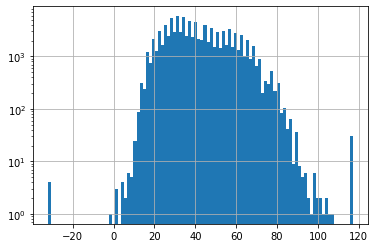

In [137]:
df_client['age'].hist(bins = 100)
plt.yscale('log')

<0 5
<18 1901
>80 525
>100 38


<AxesSubplot:>

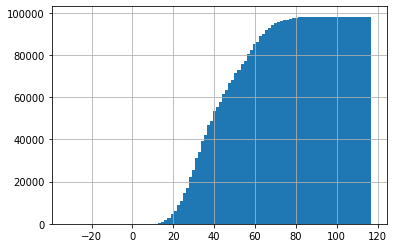

In [141]:
print('<0', (df_client['age']<0).sum())
print('<18', (df_client['age']<18).sum())
print('>80', (df_client['age']>80).sum())
print('>100', (df_client['age']>100).sum())

df_client['age'].hist(bins = 100, cumulative=1)


In [142]:
# Среди 5-ти клиентов с возрастом меньше 0, 3-е - churn
df_client[(df_client['age']<0)]

,t_min,t_max,_t_list,items_N,items_sales_sum_sum,items_sales_count_sum,items_N_negative,items_sales_sum_sum_negative,items_sales_count_sum_negative,item_price_mean,...,plant_val_1,material_key_1,material_val_1,client_id,gender,city,birthyear,_t_list2,is_male,age
client_id,,,,,,,,,,,,,,,,,,,,,
1c3b9a73e5b3e5d19e7cddf248148e42,2016-10-11,2017-09-22,"[2016-10-11T00:00:00.000000000, 2016-10-14T00:...",10,13587.0,88.748,0,0.0,0.0,12.997800,...,0.200000,4ac3f7e19cddd61cdedc13d8c5fcd7f5,0.025000,1c3b9a73e5b3e5d19e7cddf248148e42,M,St. Petersburg,2019.0,"[2016-10-11T00:00:00.000000000, 2016-10-14T00:...",1,-2.0
28b2664fda7815ce00b73810c489f1c9,2016-10-11,2017-07-02,"[2016-10-11T00:00:00.000000000, 2016-10-21T00:...",12,7764.0,53.579,0,0.0,0.0,6.237109,...,0.333333,014a1a520e903a8e84e591b0a02dbcb3,0.036364,28b2664fda7815ce00b73810c489f1c9,M,Other,2049.0,"[2016-10-11T00:00:00.000000000, 2016-10-21T00:...",1,-32.0
c449c75d70475b8d334e6ebecf1d1bb2,2016-10-09,2017-06-22,"[2016-10-09T00:00:00.000000000, 2016-11-19T00:...",5,23290.0,184.393,0,0.0,0.0,47.436784,...,0.200000,401c45818daaddaab09f256c08763ad3,0.037313,c449c75d70475b8d334e6ebecf1d1bb2,F,Other,2049.0,"[2016-10-09T00:00:00.000000000, 2016-11-19T00:...",-1,-32.0
d857674442d57378e236586013182fb5,2016-11-04,2017-03-21,"[2016-11-04T00:00:00.000000000, 2016-11-05T00:...",4,5449.0,49.476,0,0.0,0.0,16.823238,...,NaN,682b760ebe9651f7d6356ffd55b100a7,0.071429,d857674442d57378e236586013182fb5,M,Other,2049.0,"[2016-11-04T00:00:00.000000000, 2016-11-05T00:...",1,-32.0
f299f074dce4ff76503aa396ff638d0b,2016-10-04,2017-09-27,"[2016-10-04T00:00:00.000000000, 2016-10-05T00:...",16,38101.0,582.783,0,0.0,0.0,39.972134,...,NaN,ab17bf24039893348f6b9f23753f38ca,0.019802,f299f074dce4ff76503aa396ff638d0b,F,Other,2049.0,"[2016-10-04T00:00:00.000000000, 2016-10-05T00:...",-1,-32.0


In [143]:
# Добавим признак странный год
df_client['age_correct'] = (df_client['age']<0) | (df_client['age']>80)

In [146]:
# Добавим признак количество нанов в данных
df_client['is_na(all)'] = df_client.isna().sum(axis = 1)
df_client['is_na(all)'].max()

19

In [149]:
features = ["items_N", "items_N_negative", "item_price_max", "chq_id_len_min",
            "chq_id_len_max", "items_N_positive", "items_sales_sum_sum", "items_sales_count_sum", 
            "items_sales_sum_sum_negative", "items_sales_count_sum_negative", 
            "item_price_mean", "item_price_min", "chq_id_sum_sales_count_mean",
            "chq_id_len_mean", "chq_id_sum_sales_sum_mean", "chq_id_sum_sales_count_min",
            "chq_id_sum_sales_sum_min", "chq_id_sum_sales_count_max", "chq_id_sum_sales_sum_max", 
            "promo_rate_count", "promo_rate_sales_sum", "promo_rate_sales_count", "delta_median", 
            "delta_min", "delta_max", "delta_std", "delta_moda", "items_sales_sum_sum_positive", 
            "items_sales_count_sum_positive", "delta_bin_0_(1,)", "delta_bin_1_(7,)", "delta_bin_7_(14,)",
            "delta_bin_14_(21,)", "delta_bin_21_(28,)", "delta_bin_28_(56,)", "delta_bin_56_(112,)",
            "delta_bin_112_(224,)", "delta_bin_224_(448,)", "plant_val_0", "material_val_0", "plant_val_1", 
            "material_val_1", "birthyear", "is_male", "age", "age_correct", "is_na(all)"]

df_client['is_na(features)'] = df_client[features].isna().sum(axis = 1)
features += ["is_na(features)"]

In [ ]:
all_users_list

In [178]:
df_client['y'] = df_client['client_id'].isin(churn_users).astype(int)

In [180]:
df_client['y'].mean()

0.32603

In [181]:
train_users, test_users, _, _ = train_test_split(all_users_list, 
                                                 all_users_list,
                                                 test_size = 0.3,
                                                 random_state = 42)

In [182]:
df_train = df_client.loc[train_users, features]
df_test  = df_client.loc[test_users,  features]

y_train = df_client.loc[train_users, 'y']
y_test  = df_client.loc[test_users,  'y']



In [184]:
# df_train.mean()
# (X_train-1).isna().sum()
# (df_train>1e8).sum().sum()
# X_train.to_numpy()[:, :2]
# y_train

In [185]:
X_train = df_train.fillna(df_train.mean())
X_test  = df_test.fillna(df_test.mean())

# X_train = df_train.fillna(df_train.mean())

In [221]:
model = make_pipeline(StandardScaler(),
                      LogisticRegression(penalty='l1',
                                         C = 0.01,
                                         solver = 'liblinear'))

model.fit(X_train.to_numpy(), y_train)

p_train = model.predict_proba(X_train)[:, 1]
p_test  = model.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report
print('train')
print(classification_report(y_train, p_train>0.5))

print('test')
print(classification_report(y_test, p_test>0.5))

feature_importance = {k:v for k,v in sorted(zip(features, model.steps[1][1].coef_[0]), key = lambda x:abs(x[1]))}
feature_importance

train
              precision    recall  f1-score   support

           0       0.87      0.94      0.91     47177
           1       0.86      0.71      0.78     22823

    accuracy                           0.87     70000
   macro avg       0.86      0.83      0.84     70000
weighted avg       0.87      0.87      0.86     70000

test
              precision    recall  f1-score   support

           0       0.87      0.94      0.90     20220
           1       0.85      0.71      0.78      9780

    accuracy                           0.87     30000
   macro avg       0.86      0.83      0.84     30000
weighted avg       0.86      0.87      0.86     30000



In [223]:
from sklearn.tree import DecisionTreeClassifier

In [240]:
model = DecisionTreeClassifier(max_depth=3)#De(n_estimators = 10)

model.fit(X_train.to_numpy(), y_train)

p_train = model.predict_proba(X_train)[:, 1]
p_test  = model.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report
print('train')
print(classification_report(y_train, p_train>0.5))

print('test')
print(classification_report(y_test, p_test>0.5))



train
              precision    recall  f1-score   support

           0       0.84      0.92      0.88     47177
           1       0.80      0.63      0.71     22823

    accuracy                           0.83     70000
   macro avg       0.82      0.78      0.79     70000
weighted avg       0.83      0.83      0.82     70000

test
              precision    recall  f1-score   support

           0       0.84      0.92      0.88     20220
           1       0.80      0.63      0.71      9780

    accuracy                           0.83     30000
   macro avg       0.82      0.78      0.79     30000
weighted avg       0.83      0.83      0.82     30000



In [228]:
# model
!pip install graphviz

In [275]:
df['chq_date'].min()

Timestamp('2016-10-04 00:00:00')

In [241]:
import graphviz 
from sklearn import tree
dot_data = tree.export_graphviz(model, out_file='tree_depth3.dot', feature_names=features) 

In [243]:
df_client.shape

(100000, 60)

In [ ]:
# Написать precision/recall curve
# Настроить кросс валидацию
# Попробовать RF
# ВИзуализировать признаки

In [216]:
p_train = model.predict_proba(X_train)[:, 1]
p_test  = model.predict_proba(X_test)[:, 1]

In [217]:
from sklearn.metrics import classification_report
print('train')
print(classification_report(y_train, p_train>0.5))

print('test')
print(classification_report(y_test, p_test>0.5))

train
              precision    recall  f1-score   support

           0       0.87      0.94      0.90     47177
           1       0.85      0.72      0.78     22823

    accuracy                           0.87     70000
   macro avg       0.86      0.83      0.84     70000
weighted avg       0.87      0.87      0.86     70000

test
              precision    recall  f1-score   support

           0       0.87      0.94      0.90     20220
           1       0.85      0.72      0.78      9780

    accuracy                           0.87     30000
   macro avg       0.86      0.83      0.84     30000
weighted avg       0.86      0.87      0.86     30000



In [205]:
from sklearn.metrics import classification_report
print('train')
print(classification_report(y_train, p_train>0.5))

print('test')
print(classification_report(y_test, p_test>0.5))

train
              precision    recall  f1-score   support

           0       0.87      0.94      0.90     47177
           1       0.85      0.72      0.78     22823

    accuracy                           0.87     70000
   macro avg       0.86      0.83      0.84     70000
weighted avg       0.87      0.87      0.86     70000

test
              precision    recall  f1-score   support

           0       0.87      0.94      0.90     20220
           1       0.84      0.72      0.78      9780

    accuracy                           0.87     30000
   macro avg       0.86      0.83      0.84     30000
weighted avg       0.86      0.87      0.86     30000



In [ ]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()


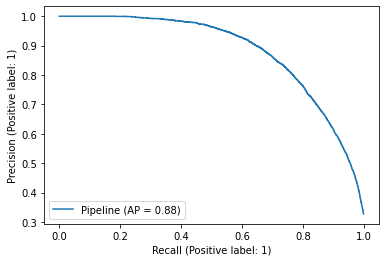

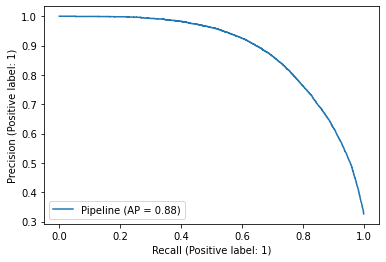

In [212]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(model, X_test, y_test)
disp = plot_precision_recall_curve(model, X_train, y_train)

# average_precision = average_precision_score(X_test, )
# disp.ax_.set_title('2-class Precision-Recall curve: '
#                    'AP={0:0.2f}'.format(average_precision))

In [218]:
feature_importance = {k:v for k,v in sorted(zip(features, model.steps[1][1].coef_[0]), key = lambda x:abs(x[1]))}
feature_importance

{'chq_id_len_max': 0.0,
 'chq_id_sum_sales_sum_max': 0.0,
 'delta_bin_0_(1,)': 0.0,
 'delta_bin_21_(28,)': 0.0,
 'is_na(all)': 0.0,
 'chq_id_sum_sales_count_min': -0.002155834805621432,
 'items_sales_count_sum_positive': -0.00368816159928755,
 'promo_rate_sales_count': 0.004677769017567101,
 'item_price_min': -0.004786325270357058,
 'chq_id_sum_sales_sum_min': -0.005060434088804737,
 'promo_rate_count': -0.009255940426158847,
 'is_male': 0.011335926204725563,
 'age': -0.01269474839879686,
 'items_sales_sum_sum_negative': -0.022783787563577556,
 'age_correct': 0.023561665838766,
 'promo_rate_sales_sum': -0.03278176999456142,
 'items_N_negative': -0.034543627047839934,
 'birthyear': 0.03796428785628833,
 'material_val_0': 0.040682227947736425,
 'delta_bin_14_(21,)': 0.043814141379954964,
 'plant_val_0': 0.05567317484679588,
 'items_sales_count_sum': -0.06016042210421126,
 'plant_val_1': 0.08701548963078373,
 'chq_id_len_mean': 0.09298091954237249,
 'delta_bin_28_(56,)': -0.10955036554596

In [214]:
feature_importance

{'items_sales_count_sum': 0.0,
 'item_price_min': 0.0,
 'chq_id_sum_sales_sum_min': 0.0,
 'items_sales_count_sum_positive': 0.0,
 'delta_bin_0_(1,)': 0.0,
 'birthyear': 0.0011917005954920896,
 'chq_id_sum_sales_sum_max': -0.005160238903197928,
 'chq_id_sum_sales_count_min': -0.005638190927557788,
 'is_male': 0.012126569970261219,
 'age_correct': 0.024975405204540384,
 'promo_rate_sales_count': 0.028266432265449042,
 'promo_rate_count': -0.030693093221579197,
 'items_N_negative': -0.03303659422644385,
 'promo_rate_sales_sum': -0.03507894874546941,
 'material_val_0': 0.04261765870955812,
 'delta_bin_7_(14,)': 0.04635144828514831,
 'age': -0.0506717676382598,
 'items_sales_sum_sum_negative': -0.054694009255778185,
 'delta_bin_14_(21,)': -0.0909398210533539,
 'plant_val_0': 0.09420116932845037,
 'plant_val_1': 0.10874818912225177,
 'chq_id_sum_sales_count_max': -0.1107296759080137,
 'items_sales_count_sum_negative': -0.11610677792210096,
 'delta_bin_21_(28,)': -0.11903406289888956,
 'item_

In [145]:
df_client['is_na(features)'] = df_client.isna().sum(axis = 1)

client_id
0000d48a8891cd462fdf01ea861ec53e    0
00028a1dcb30863404a386961a69300e    0
0004274683494a9eca5e70ef97299d55    0
00072f81efcb3481861f7300c5e2a88a    2
00076596eb749cf10c2e984621dffe95    0
                                   ..
fffb2f36eb72ff56d2ef7a2685714f01    0
fffb50df95231c0f090b5aa3f5332c7f    0
fffc3f2be1422d248dbeda4196ef0711    2
fffc477269ae5f219e39aa51fa7abb81    2
fffd3e78e3ea6bf00aee1372efc09dad    0
Length: 100000, dtype: int64

In [124]:
df_client['birthyear'].drop_duplicates().sort_values()#.dropna()

client_id
065c5a53199470856d8f88338a0a0550    1900.0
c55c136f347cb1f5c017fb3121a92f44    1901.0
053aeeca0d17f0356f17b9990521d8db    1909.0
dc0846d55ea7d65e17f5aa33e25db300    1911.0
1b9c7fb886df5f83a96cca09df4cc9b6    1912.0
                                     ...  
40612f1c88f87f14179d680dd80dee28    2015.0
1a746b2631f45c6532ab4008de33d46f    2016.0
1c3b9a73e5b3e5d19e7cddf248148e42    2019.0
28b2664fda7815ce00b73810c489f1c9    2049.0
0017625e34ece8ecb7f8ecaa5a3716a1       NaN
Name: birthyear, Length: 108, dtype: float64

<AxesSubplot:>

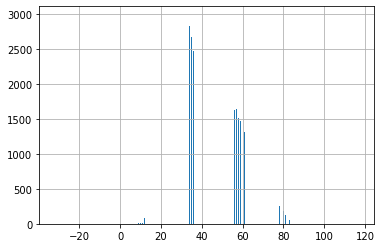

In [117]:
(2017-df_client['birthyear']).fillna(-1).hist(bins = 2017)

In [ ]:
items_N	int64
items_N_negative	int64
item_price_max	int64
chq_id_len_min	int64
chq_id_len_max	int64
items_N_positive	int64
items_sales_sum_sum	float64
items_sales_count_sum	float64
items_sales_sum_sum_negative	float64
items_sales_count_sum_negative	float64
item_price_mean	float64
item_price_min	float64
chq_id_sum_sales_count_mean	float64
chq_id_len_mean	float64
chq_id_sum_sales_sum_mean	float64
chq_id_sum_sales_count_min	float64
chq_id_sum_sales_sum_min	float64
chq_id_sum_sales_count_max	float64
chq_id_sum_sales_sum_max	float64
promo_rate_count	float64
promo_rate_sales_sum	float64
promo_rate_sales_count	float64
delta_median	float64
delta_min	float64
delta_max	float64
delta_std	float64
delta_moda	float64
items_sales_sum_sum_positive	float64
items_sales_count_sum_positive	float64
delta_bin_0_(1,)	float64
delta_bin_1_(7,)	float64
delta_bin_7_(14,)	float64
delta_bin_14_(21,)	float64
delta_bin_21_(28,)	float64
delta_bin_28_(56,)	float64
delta_bin_56_(112,)	float64
delta_bin_112_(224,)	float64
delta_bin_224_(448,)	float64
plant_val_0	float64
material_val_0	float64
plant_val_1	float64
material_val_1	float64
birthyear	float64

In [ ]:
items_N
items_N_negative
item_price_max
chq_id_len_min
chq_id_len_max
items_N_positive
items_sales_sum_sum
items_sales_count_sum
items_sales_sum_sum_negative
items_sales_count_sum_negative
item_price_mean
item_price_min
chq_id_sum_sales_count_mean
chq_id_len_mean
chq_id_sum_sales_sum_mean
chq_id_sum_sales_count_min
chq_id_sum_sales_sum_min
chq_id_sum_sales_count_max
chq_id_sum_sales_sum_max
promo_rate_count
promo_rate_sales_sum
promo_rate_sales_count
delta_median
delta_min
delta_max
delta_std
delta_moda
items_sales_sum_sum_positive
items_sales_count_sum_positive
delta_bin_0_(1,)
delta_bin_1_(7,)
delta_bin_7_(14,)
delta_bin_14_(21,)
delta_bin_21_(28,)
delta_bin_28_(56,)
delta_bin_56_(112,)
delta_bin_112_(224,)
delta_bin_224_(448,)
plant_val_0
material_val_0
plant_val_1
material_val_1
birthyear
is_male
age

In [106]:
print('\n'.join(i for i,k in lst))

t_min
t_max
items_N
items_N_negative
item_price_max
chq_id_len_min
chq_id_len_max
items_N_positive
items_sales_sum_sum
items_sales_count_sum
items_sales_sum_sum_negative
items_sales_count_sum_negative
item_price_mean
item_price_min
chq_id_sum_sales_count_mean
chq_id_len_mean
chq_id_sum_sales_sum_mean
chq_id_sum_sales_count_min
chq_id_sum_sales_sum_min
chq_id_sum_sales_count_max
chq_id_sum_sales_sum_max
promo_rate_count
promo_rate_sales_sum
promo_rate_sales_count
delta_median
delta_min
delta_max
delta_std
delta_moda
items_sales_sum_sum_positive
items_sales_count_sum_positive
delta_bin_0_(1,)
delta_bin_1_(7,)
delta_bin_7_(14,)
delta_bin_14_(21,)
delta_bin_21_(28,)
delta_bin_28_(56,)
delta_bin_56_(112,)
delta_bin_112_(224,)
delta_bin_224_(448,)
plant_val_0
material_val_0
plant_val_1
material_val_1
birthyear
_t_list
plant_key_0
material_key_0
plant_key_1
material_key_1
client_id
gender
city
_t_list2


In [94]:
len(not_churn_users_list)

67397

In [84]:
%%time
df.groupby('client_id').apply(len)

CPU times: user 13.5 s, sys: 2.33 s, total: 15.8 s
Wall time: 15.8 s


client_id
0000d48a8891cd462fdf01ea861ec53e     616
00028a1dcb30863404a386961a69300e     386
0004274683494a9eca5e70ef97299d55    1200
00072f81efcb3481861f7300c5e2a88a      29
00076596eb749cf10c2e984621dffe95    2139
                                    ... 
fffb2f36eb72ff56d2ef7a2685714f01     354
fffb50df95231c0f090b5aa3f5332c7f     195
fffc3f2be1422d248dbeda4196ef0711     215
fffc477269ae5f219e39aa51fa7abb81     160
fffd3e78e3ea6bf00aee1372efc09dad      26
Length: 100000, dtype: int64

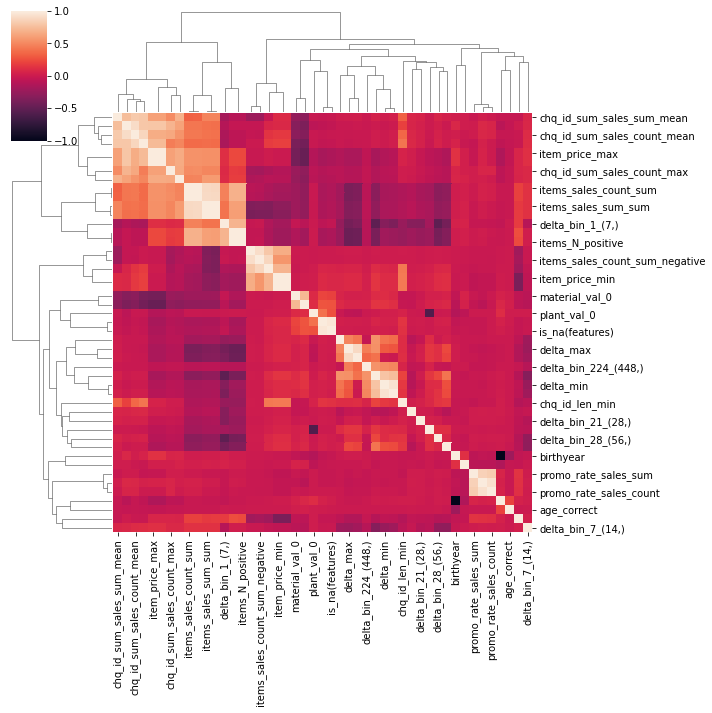

In [274]:
import seaborn as sns; 
# sns.set_theme(color_codes=True)
# iris = sns.load_dataset("iris")
# species = iris.pop("species")
g = sns.clustermap(X_train[features].drop("delta_bin_0_(1,)", axis = 1).corr())

In [249]:
X_train[features].isna().sum().sum()

0

In [273]:
X_train[features].drop("delta_bin_0_(1,)", axis = 1).corr().max()

items_N                           1.0
items_N_negative                  1.0
item_price_max                    1.0
chq_id_len_min                    1.0
chq_id_len_max                    1.0
items_N_positive                  1.0
items_sales_sum_sum               1.0
items_sales_count_sum             1.0
items_sales_sum_sum_negative      1.0
items_sales_count_sum_negative    1.0
item_price_mean                   1.0
item_price_min                    1.0
chq_id_sum_sales_count_mean       1.0
chq_id_len_mean                   1.0
chq_id_sum_sales_sum_mean         1.0
chq_id_sum_sales_count_min        1.0
chq_id_sum_sales_sum_min          1.0
chq_id_sum_sales_count_max        1.0
chq_id_sum_sales_sum_max          1.0
promo_rate_count                  1.0
promo_rate_sales_sum              1.0
promo_rate_sales_count            1.0
delta_median                      1.0
delta_min                         1.0
delta_max                         1.0
delta_std                         1.0
delta_moda  

In [267]:
X_train['delta_bin_0_(1,)'].nunique()

1

In [272]:
X_train[features].drop("delta_bin_0_(1,)", axis = 1)

,items_N,items_N_negative,item_price_max,chq_id_len_min,chq_id_len_max,items_N_positive,items_sales_sum_sum,items_sales_count_sum,items_sales_sum_sum_negative,items_sales_count_sum_negative,...,plant_val_0,material_val_0,plant_val_1,material_val_1,birthyear,is_male,age,age_correct,is_na(all),is_na(features)
client_id,,,,,,,,,,,,,,,,,,,,,
133ed3bb209ddc7383e254d0fb53863a,23,0,32,1,32,23,9340.00,149.680,0.00,0.0,...,0.739130,0.061644,0.260870,0.041096,1999.0,1,18.0,False,0,0
6abe202cb6f40d46af0d1d5bab062535,41,0,49,2,49,41,86306.00,733.151,0.00,0.0,...,1.000000,0.016845,0.194454,0.015314,1965.0,-1,52.0,False,2,1
ef9f3dc0ca47a50dc475f13f89904eab,16,0,30,5,30,16,26021.00,552.502,0.00,0.0,...,0.937500,0.059406,0.062500,0.049505,1964.0,-1,53.0,False,0,0
39f9eb671bc600d9206655e80809e08a,59,1,12,1,12,58,11115.21,181.765,-75.80,-1.0,...,0.966102,0.123656,0.033898,0.037634,1968.0,-1,49.0,False,0,0
98bbe7f517f3004c4bc77b04f970f455,27,0,9,1,9,27,7601.01,148.014,0.00,0.0,...,0.962963,0.061856,0.037037,0.061856,1973.0,-1,44.0,False,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152d0ca186b7caf89b0fccf5fca52561,11,0,28,1,28,11,34332.00,207.363,0.00,0.0,...,0.909091,0.048780,0.090909,0.048780,1990.0,-1,27.0,False,0,0
cd3387f0fb7e3514796922cc5ec0135d,10,0,3,1,3,10,2137.01,19.960,0.00,0.0,...,1.000000,0.058824,0.194454,0.058824,1951.0,-1,66.0,False,2,1
73c218778386f0da989cd506150fb761,25,1,9,1,9,24,11462.29,91.669,-420.54,-1.0,...,0.960000,0.041667,0.040000,0.041667,1987.0,-1,30.0,False,0,0
